In [1]:
import pandas as pd
import numpy as np
import joblib
import os
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import RandomizedSearchCV


In [2]:
pd.set_option('display.max_rows', None)

In [3]:
param_dist_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],        # số láng giềng để xem xét
    'weights': ['uniform', 'distance'],     # cách tính trọng số cho các láng giềng
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],  # thuật toán tìm láng giềng
    'p': [1, 2]                            # tham số khoảng cách (1 = Manhattan, 2 = Euclidean)
}


In [4]:
from sklearn.neighbors import KNeighborsClassifier
import os
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import (
    accuracy_score, f1_score, classification_report, confusion_matrix,
    roc_auc_score, roc_curve
)
from sklearn.preprocessing import label_binarize

def train_phase(phase_path, n_iter=10, random_state=42, sample=False):
    best_model = None
    best_score = 0
    all_metrics = []
    best_params = None

    for fold in range(1, 6):
        fold_path = os.path.join(phase_path, f"fold{fold}")
        scaler = joblib.load(f"{fold_path}/scaler.pkl")

        if sample:
            X_train = pd.read_csv(f"{fold_path}/X_train_resampled.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train_resampled.csv").values.ravel()
            X_train_scaled = X_train
        else:
            X_train = pd.read_csv(f"{fold_path}/X_train.csv")
            y_train = pd.read_csv(f"{fold_path}/y_train.csv").values.ravel()
            X_train_scaled = scaler.transform(X_train)
            X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns)

        X_val = pd.read_csv(f"{fold_path}/X_val.csv")
        y_val = pd.read_csv(f"{fold_path}/y_val.csv").values.ravel()
        X_val_scaled = scaler.transform(X_val)
        X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_train.columns)

        if fold == 1:
            clf = KNeighborsClassifier()
            search = RandomizedSearchCV(
                clf,
                param_distributions=param_dist_knn,
                n_iter=n_iter,
                cv=3,
                n_jobs=-1,
                verbose=1,
                scoring='f1_macro'
            )
            search.fit(X_train_scaled, y_train)
            best_params = search.best_params_
            print(f"[Fold 1] Best Parameters Found: {best_params}")

        model = KNeighborsClassifier(**best_params)
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_val_scaled)
        
        # KNN supports predict_proba, so keep it
        y_proba = model.predict_proba(X_val_scaled)

        acc = accuracy_score(y_val, y_pred)
        f1 = f1_score(y_val, y_pred, average='macro')

        classes = model.classes_
        y_val_bin = label_binarize(y_val, classes=classes)
        auc = roc_auc_score(y_val_bin, y_proba, average='macro', multi_class='ovr')

        all_metrics.append({'fold': fold, 'accuracy': acc, 'f1_macro': f1, 'auc': auc})

        if f1 > best_score:
            best_score = f1
            best_model = model
            best_scaler = scaler
            best_fold = fold

        print(f"\nFold {fold} Classification Report:\n", classification_report(y_val, y_pred))

        cm = confusion_matrix(y_val, y_pred)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=classes, yticklabels=classes)
        plt.title(f'Confusion Matrix - Fold {fold}')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.tight_layout()
        plt.show()

        plt.figure(figsize=(8, 6))
        for i, cls in enumerate(classes):
            fpr, tpr, _ = roc_curve(y_val_bin[:, i], y_proba[:, i])
            plt.plot(fpr, tpr, label=f'Class {cls}')
        plt.plot([0, 1], [0, 1], 'k--', label='Chance')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC Curve - Fold {fold}')
        plt.legend()
        plt.tight_layout()
        plt.show()

    avg_metrics = pd.DataFrame(all_metrics).mean().to_dict()
    print(f"\nAverage Accuracy: {avg_metrics['accuracy']:.4f}")
    print(f"Average F1 Macro: {avg_metrics['f1_macro']:.4f}")
    print(f"Average AUC: {avg_metrics['auc']:.4f}")

    # Không có feature_importances trong KNN nên bỏ phần này

    return best_model, best_scaler, best_fold, all_metrics




======= Training Phase 1 ========

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'weights': 'uniform', 'p': 2, 'n_neighbors': 3, 'algorithm': 'ball_tree'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.86      0.80      1785
           1       0.44      0.33      0.38       604
           2       0.43      0.27      0.33       258
           3       0.39      0.12      0.18        59
           4       0.00      0.00      0.00         9

    accuracy                           0.67      2715
   macro avg       0.40      0.32      0.34      2715
weighted avg       0.63      0.67      0.64      2715



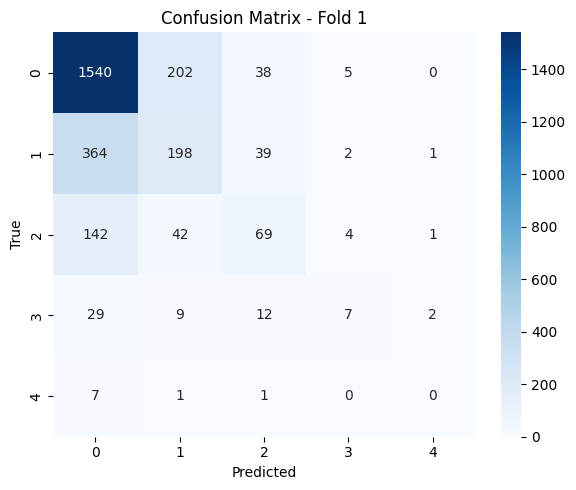

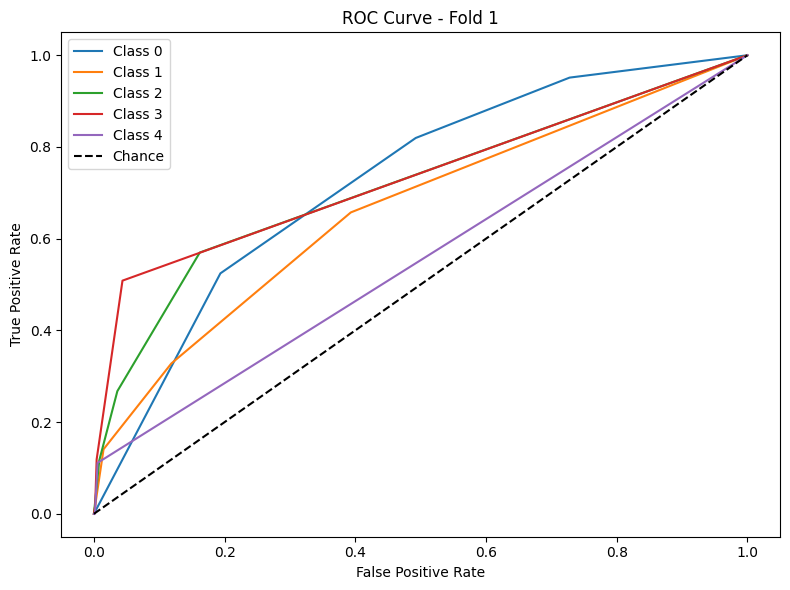

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.84      0.79      1786
           1       0.44      0.37      0.40       603
           2       0.45      0.25      0.32       258
           3       0.23      0.12      0.16        59
           4       0.00      0.00      0.00         8

    accuracy                           0.66      2714
   macro avg       0.37      0.32      0.33      2714
weighted avg       0.63      0.66      0.64      2714



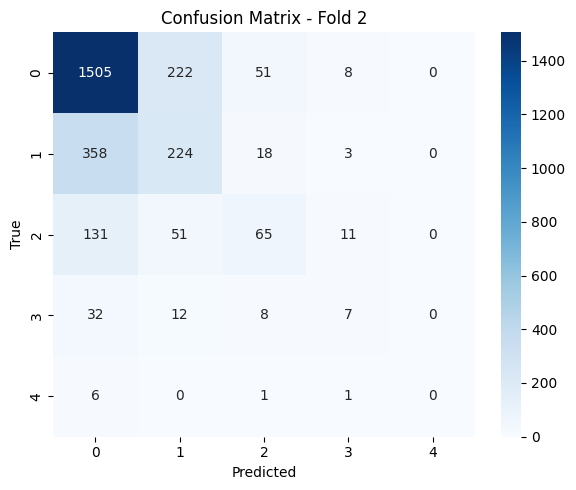

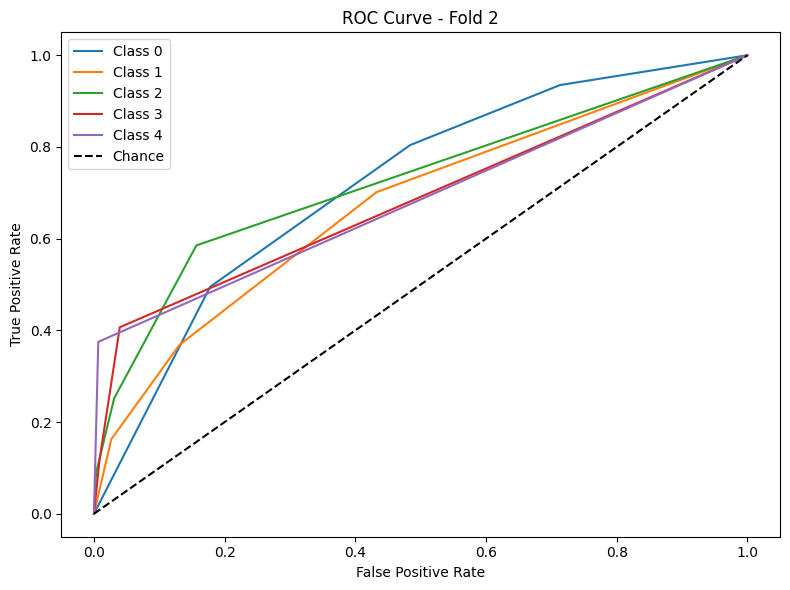


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.84      0.79      1786
           1       0.42      0.36      0.39       603
           2       0.43      0.31      0.36       258
           3       0.59      0.22      0.32        59
           4       0.00      0.00      0.00         8

    accuracy                           0.67      2714
   macro avg       0.44      0.35      0.37      2714
weighted avg       0.64      0.67      0.65      2714



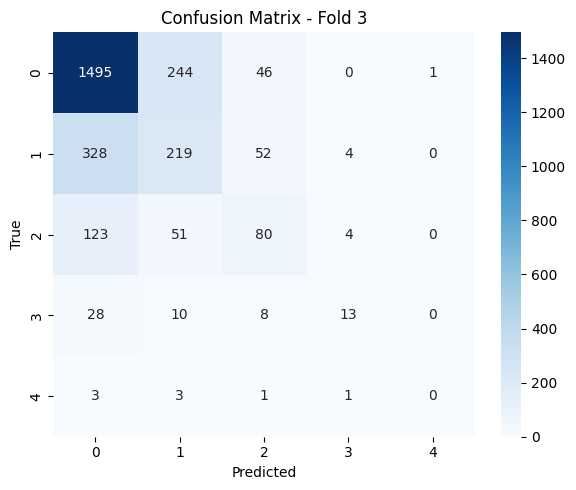

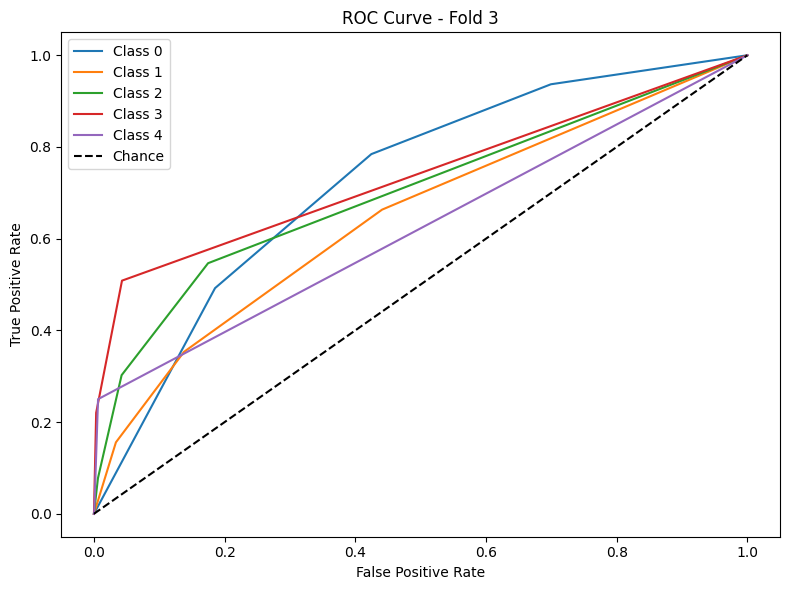


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.85      0.80      1785
           1       0.42      0.38      0.40       603
           2       0.51      0.27      0.35       258
           3       0.33      0.07      0.11        59
           4       0.00      0.00      0.00         9

    accuracy                           0.67      2714
   macro avg       0.40      0.32      0.33      2714
weighted avg       0.65      0.67      0.65      2714



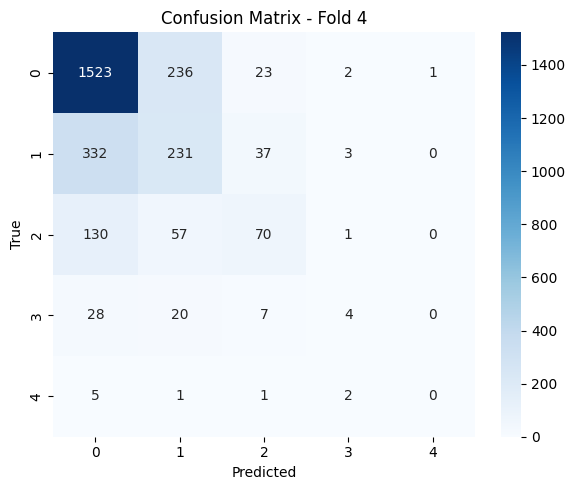

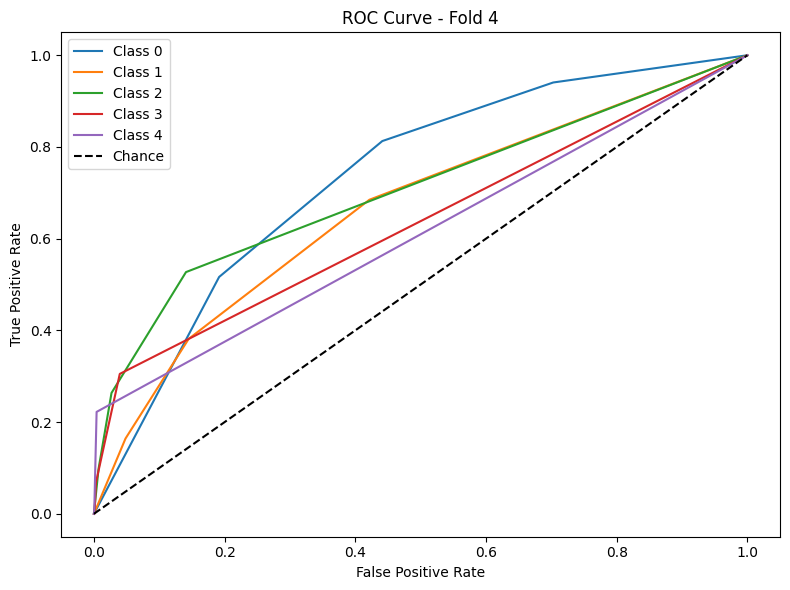


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.85      0.80      1785
           1       0.41      0.35      0.38       603
           2       0.46      0.27      0.34       258
           3       0.40      0.14      0.20        59
           4       1.00      0.11      0.20         9

    accuracy                           0.67      2714
   macro avg       0.60      0.34      0.38      2714
weighted avg       0.64      0.67      0.65      2714



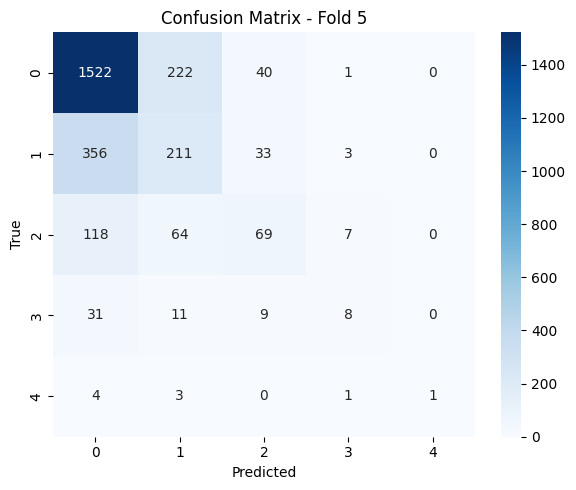

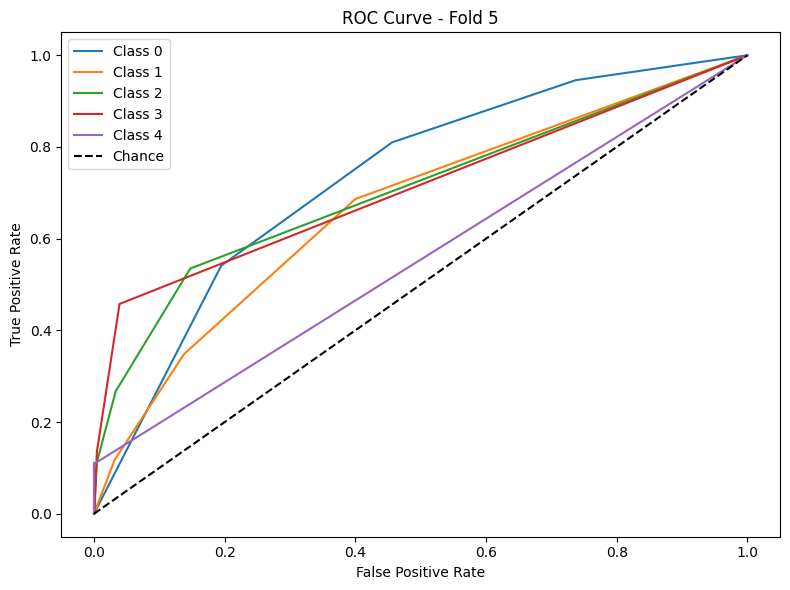


Average Accuracy: 0.6677
Average F1 Macro: 0.3522
Average AUC: 0.6812


======= Training Phase 2 ========

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'weights': 'distance', 'p': 2, 'n_neighbors': 5, 'algorithm': 'kd_tree'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.84      0.79      1489
           1       0.38      0.30      0.34       488
           2       0.39      0.31      0.34       220
           3       0.27      0.11      0.16        54
           4       0.33      0.11      0.17         9

    accuracy                           0.65      2260
   macro avg       0.43      0.34      0.36      2260
weighted avg       0.62      0.65      0.63      2260



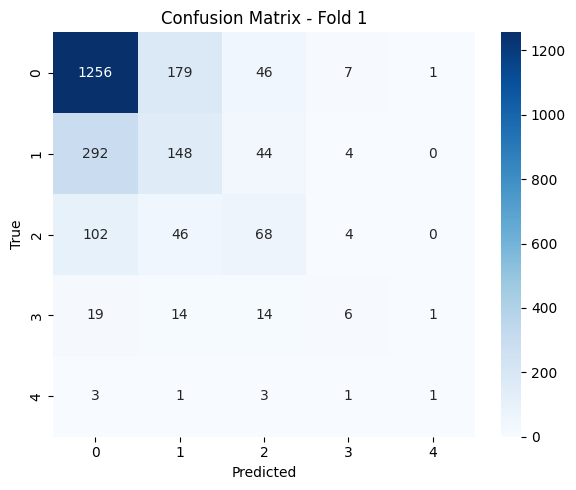

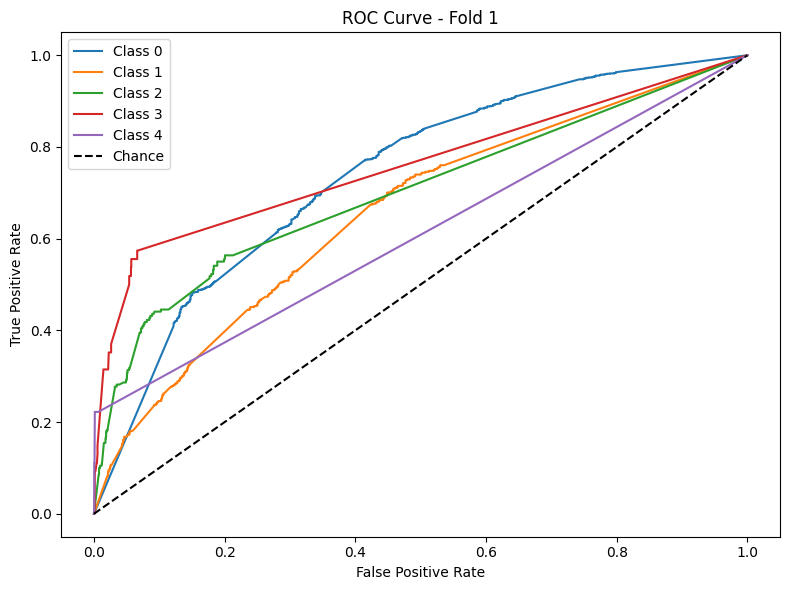


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.84      0.80      1489
           1       0.41      0.34      0.37       489
           2       0.38      0.31      0.34       219
           3       0.38      0.15      0.21        55
           4       0.00      0.00      0.00         8

    accuracy                           0.66      2260
   macro avg       0.39      0.33      0.34      2260
weighted avg       0.63      0.66      0.64      2260



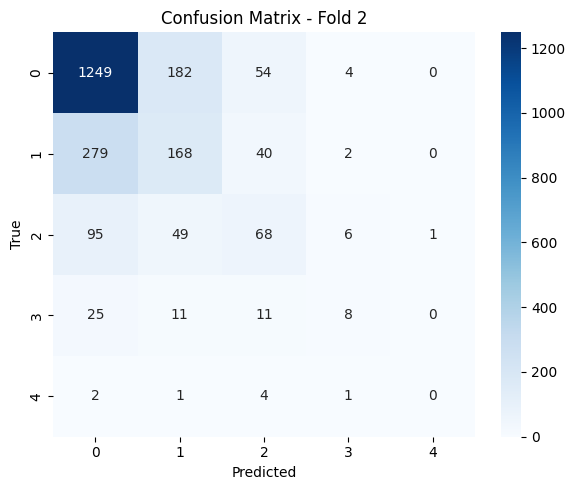

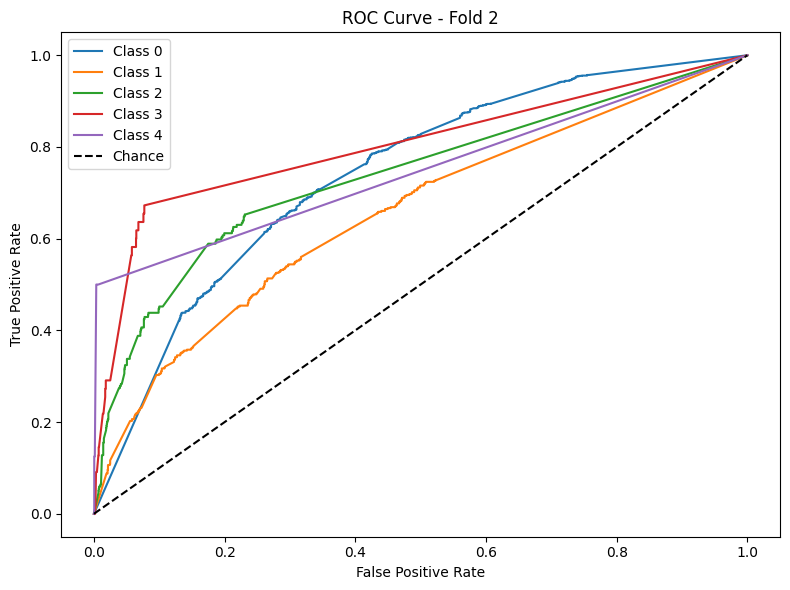


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81      1489
           1       0.37      0.32      0.34       489
           2       0.45      0.34      0.39       219
           3       0.23      0.11      0.15        54
           4       1.00      0.12      0.22         8

    accuracy                           0.67      2259
   macro avg       0.56      0.35      0.38      2259
weighted avg       0.64      0.67      0.65      2259



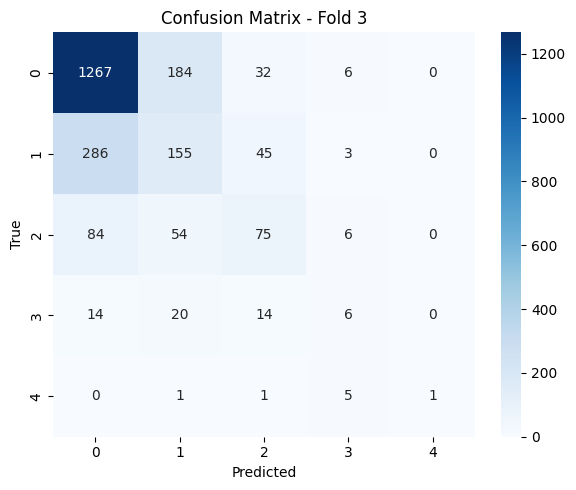

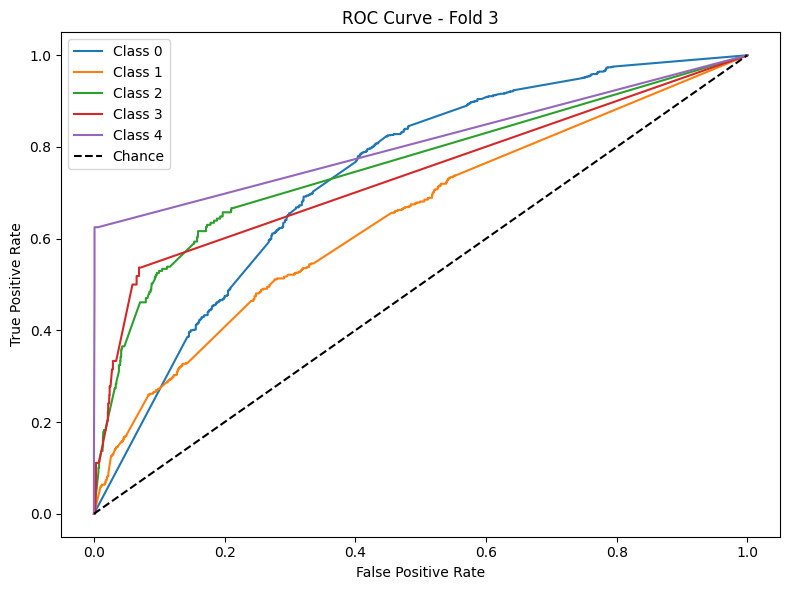


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.82      0.77      1489
           1       0.37      0.32      0.34       489
           2       0.39      0.24      0.30       219
           3       0.24      0.15      0.18        54
           4       0.44      0.50      0.47         8

    accuracy                           0.64      2259
   macro avg       0.44      0.41      0.41      2259
weighted avg       0.61      0.64      0.62      2259



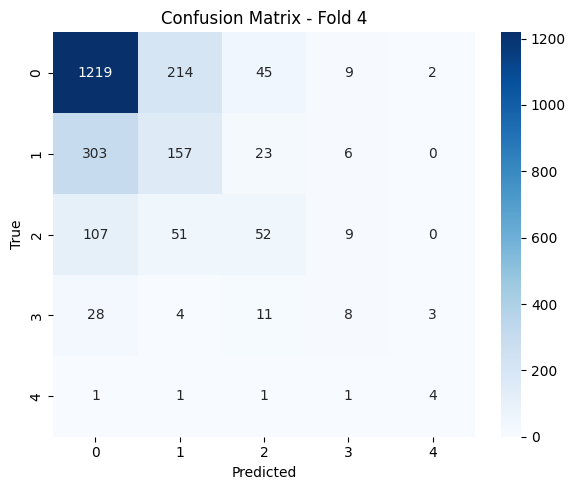

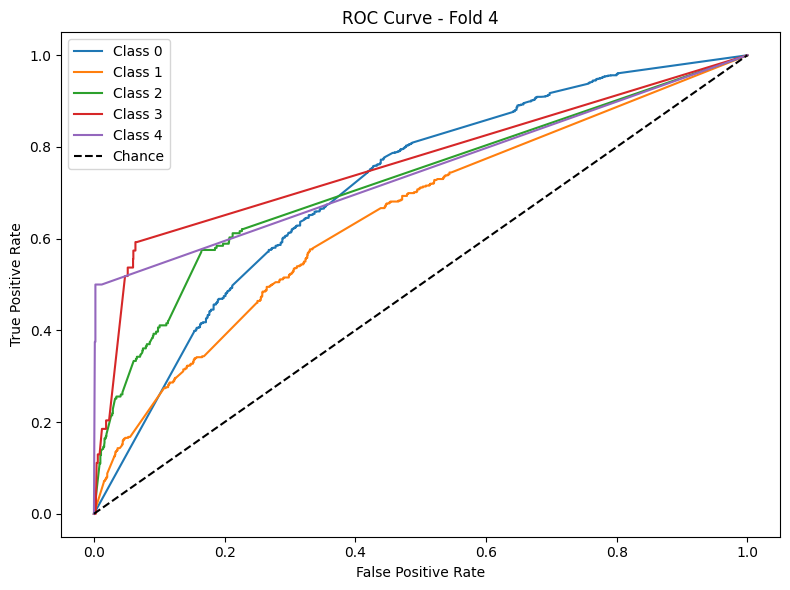


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.86      0.81      1490
           1       0.43      0.35      0.39       488
           2       0.40      0.23      0.29       219
           3       0.19      0.07      0.11        54
           4       0.12      0.12      0.12         8

    accuracy                           0.67      2259
   macro avg       0.38      0.33      0.34      2259
weighted avg       0.64      0.67      0.65      2259



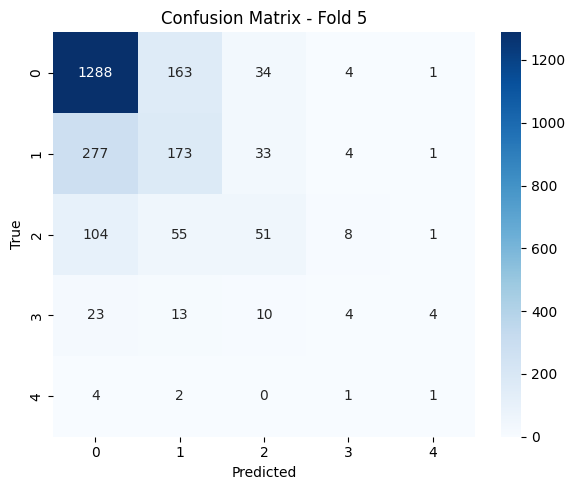

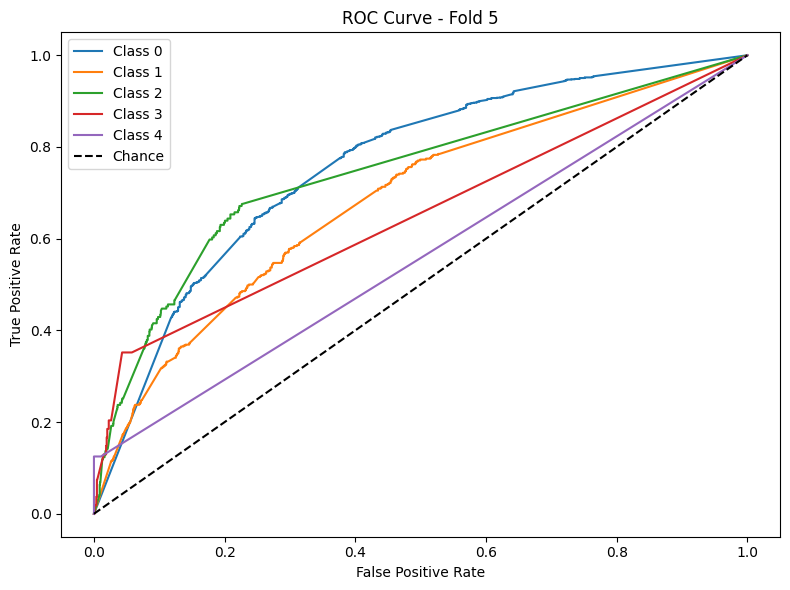


Average Accuracy: 0.6580
Average F1 Macro: 0.3690
Average AUC: 0.7129


======= Training Phase 3 ========

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'weights': 'distance', 'p': 1, 'n_neighbors': 9, 'algorithm': 'brute'}


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.88      0.81      1361
           1       0.47      0.31      0.37       459
           2       0.45      0.36      0.40       198
           3       0.21      0.18      0.20        49
           4       0.00      0.00      0.00         7

    accuracy                           0.68      2074
   macro avg       0.38      0.35      0.36      2074
weighted avg       0.65      0.68      0.66      2074



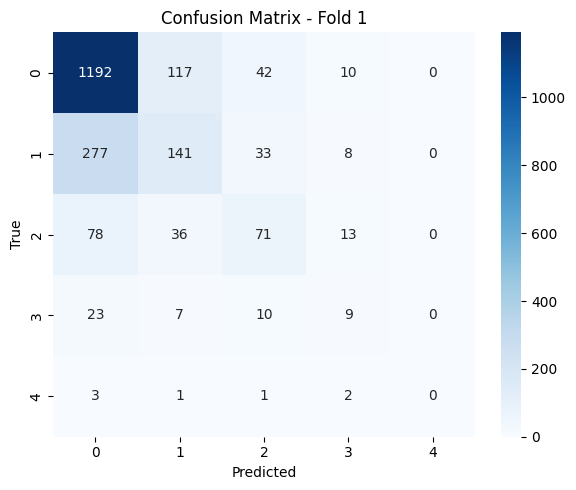

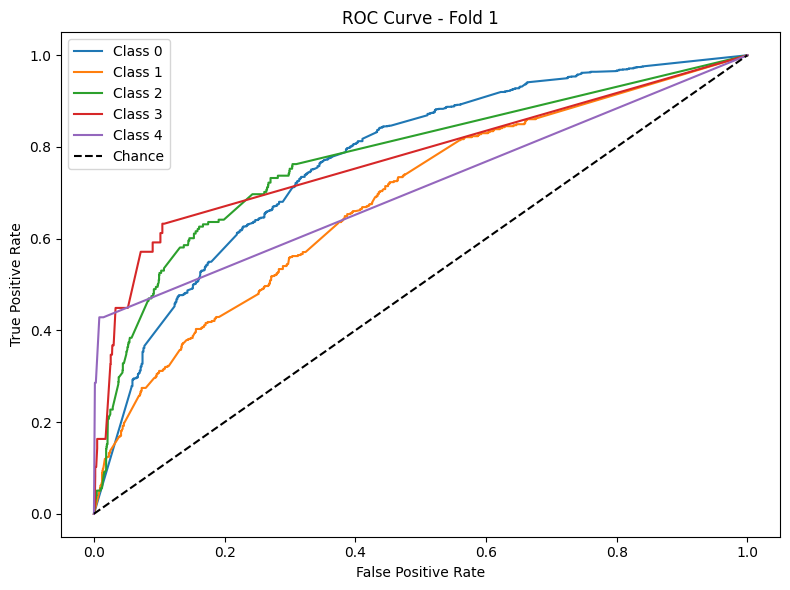


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.85      0.80      1360
           1       0.42      0.36      0.38       459
           2       0.45      0.26      0.33       198
           3       0.30      0.22      0.25        50
           4       0.50      0.14      0.22         7

    accuracy                           0.67      2074
   macro avg       0.48      0.37      0.40      2074
weighted avg       0.64      0.67      0.65      2074



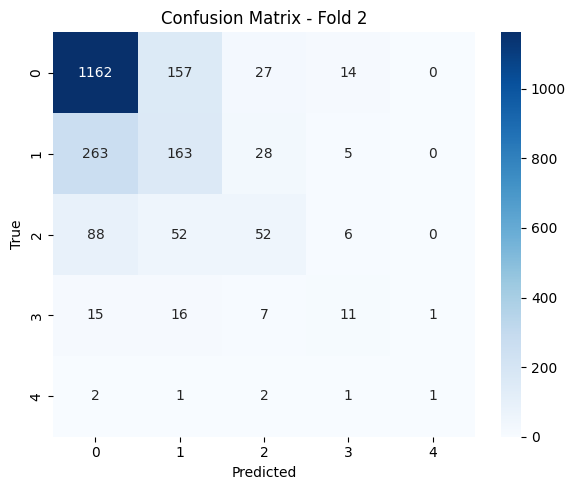

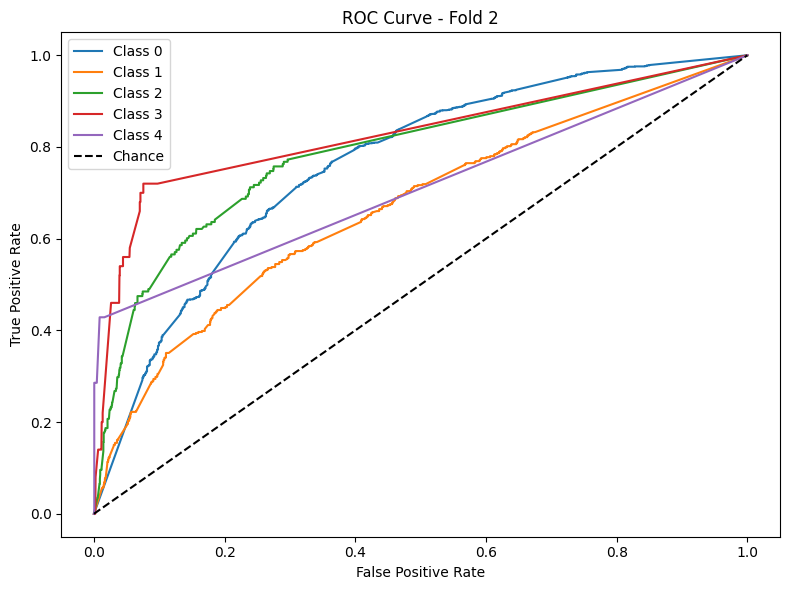


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.86      0.81      1360
           1       0.44      0.33      0.38       459
           2       0.40      0.35      0.38       198
           3       0.42      0.20      0.27        50
           4       0.33      0.14      0.20         7

    accuracy                           0.68      2074
   macro avg       0.47      0.38      0.41      2074
weighted avg       0.65      0.68      0.66      2074



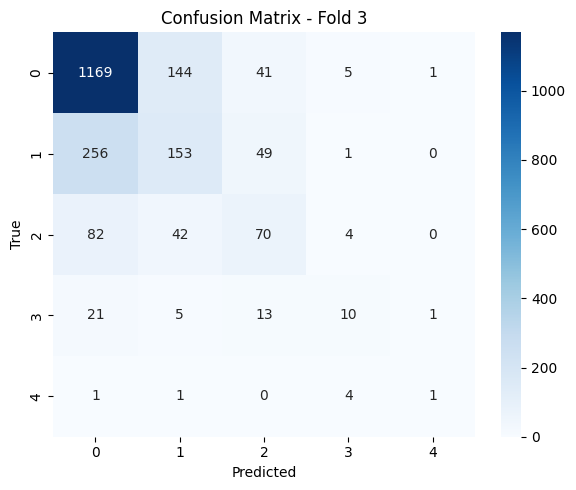

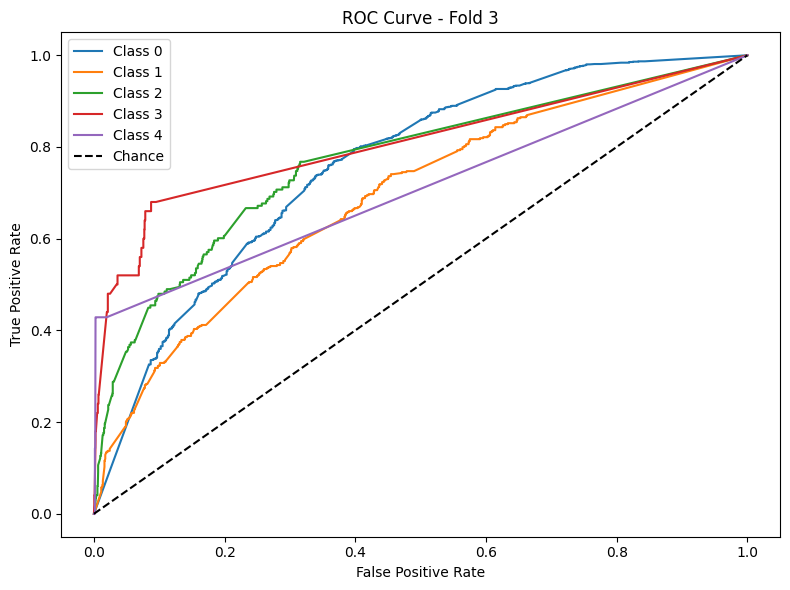


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.85      0.80      1360
           1       0.39      0.31      0.35       459
           2       0.42      0.27      0.33       198
           3       0.33      0.24      0.28        50
           4       1.00      0.14      0.25         7

    accuracy                           0.66      2074
   macro avg       0.58      0.36      0.40      2074
weighted avg       0.63      0.66      0.64      2074



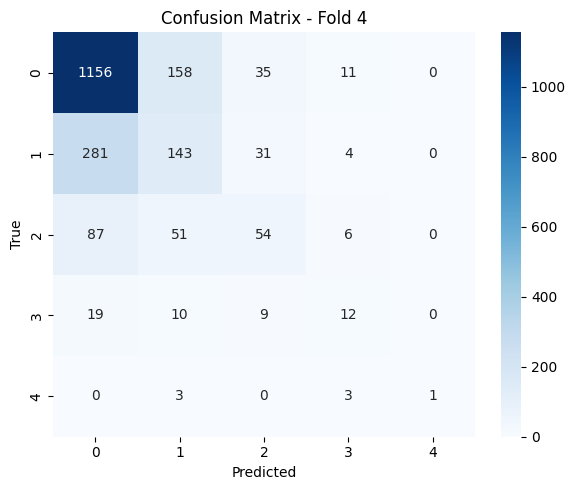

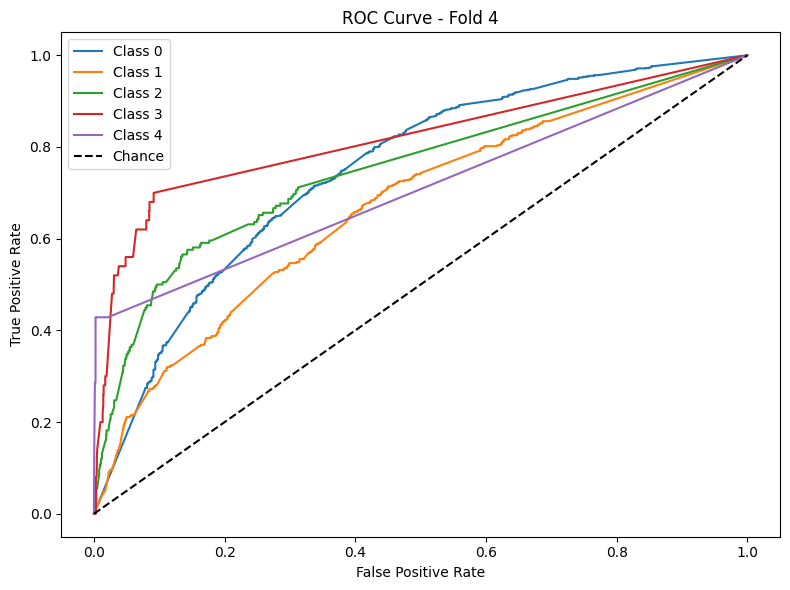


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.87      0.81      1360
           1       0.43      0.29      0.35       460
           2       0.46      0.31      0.37       197
           3       0.28      0.22      0.25        49
           4       0.00      0.00      0.00         7

    accuracy                           0.67      2073
   macro avg       0.38      0.34      0.35      2073
weighted avg       0.64      0.67      0.65      2073



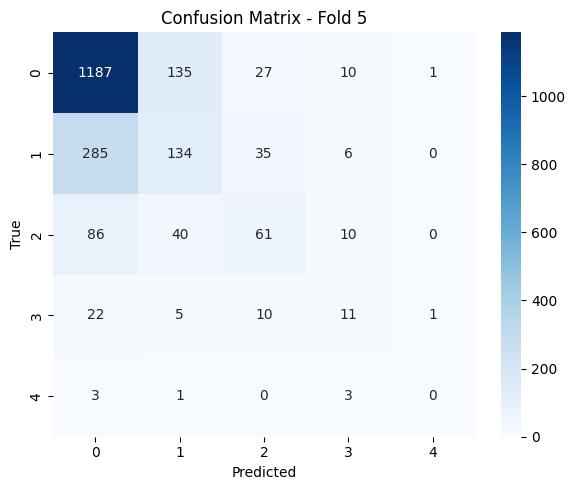

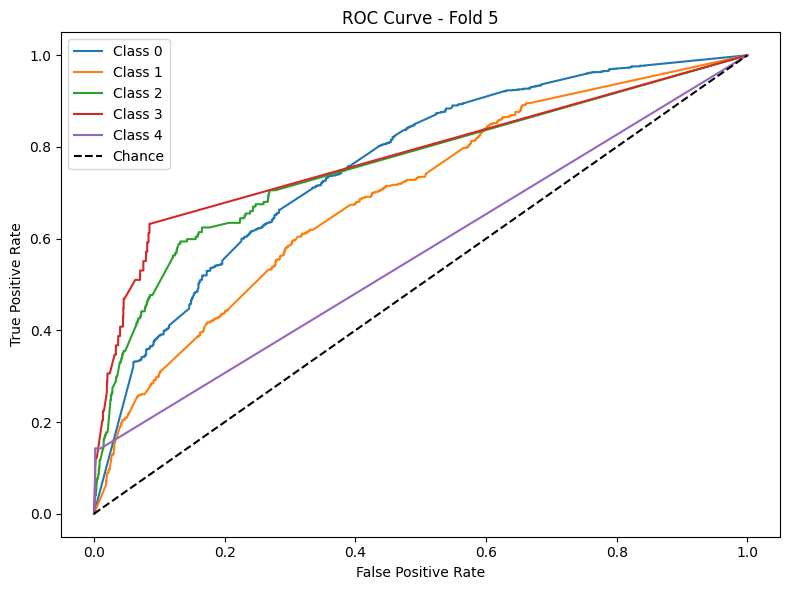


Average Accuracy: 0.6716
Average F1 Macro: 0.3834
Average AUC: 0.7381


======= Training Phase 4 ========

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'weights': 'distance', 'p': 1, 'n_neighbors': 5, 'algorithm': 'auto'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.84      0.80      1000
           1       0.44      0.35      0.39       355
           2       0.35      0.29      0.32       139
           3       0.24      0.26      0.25        39
           4       0.00      0.00      0.00         6

    accuracy                           0.66      1539
   macro avg       0.36      0.35      0.35      1539
weighted avg       0.64      0.66      0.65      1539



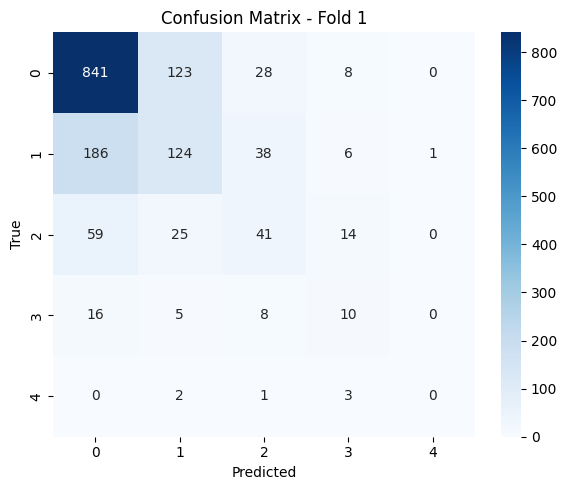

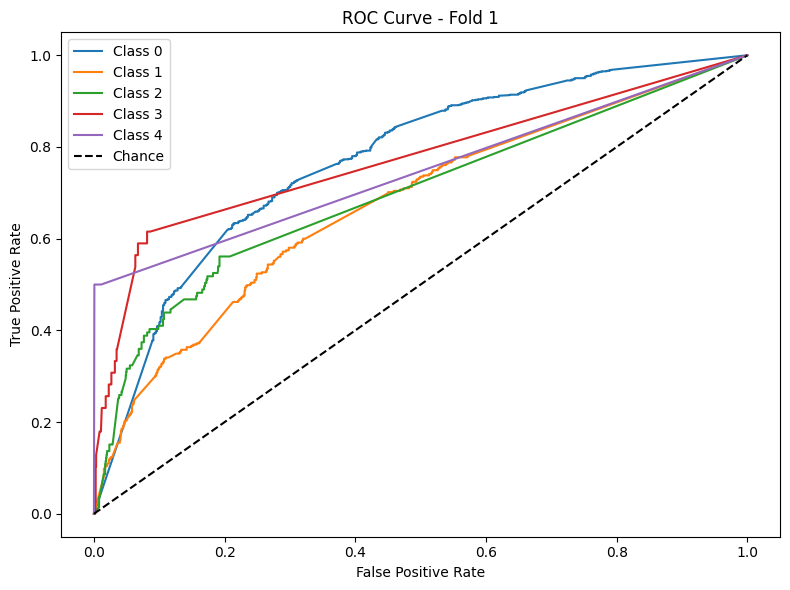


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.84      0.80      1000
           1       0.42      0.37      0.39       355
           2       0.43      0.35      0.39       139
           3       0.21      0.07      0.11        40
           4       0.20      0.20      0.20         5

    accuracy                           0.66      1539
   macro avg       0.41      0.37      0.38      1539
weighted avg       0.64      0.66      0.65      1539



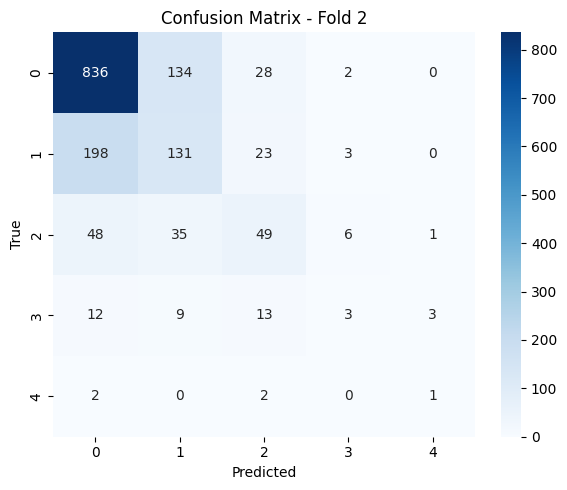

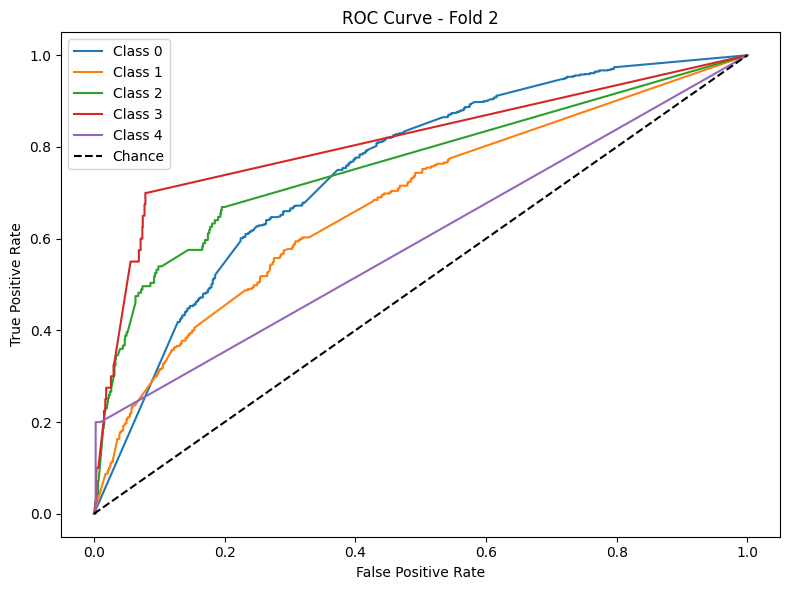


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.85      0.80       999
           1       0.46      0.39      0.42       355
           2       0.47      0.30      0.37       139
           3       0.50      0.23      0.31        40
           4       0.20      0.17      0.18         6

    accuracy                           0.68      1539
   macro avg       0.48      0.39      0.42      1539
weighted avg       0.65      0.68      0.66      1539



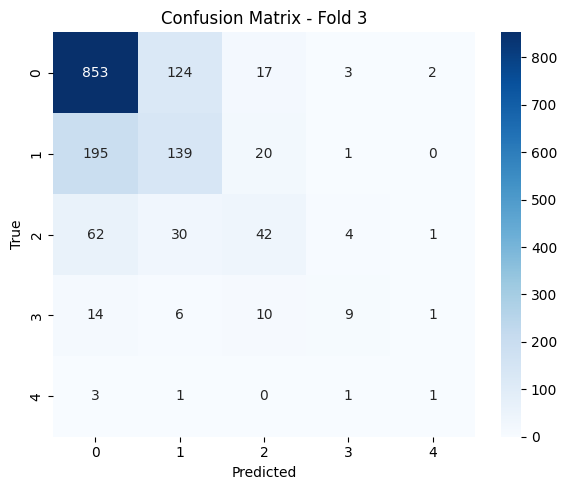

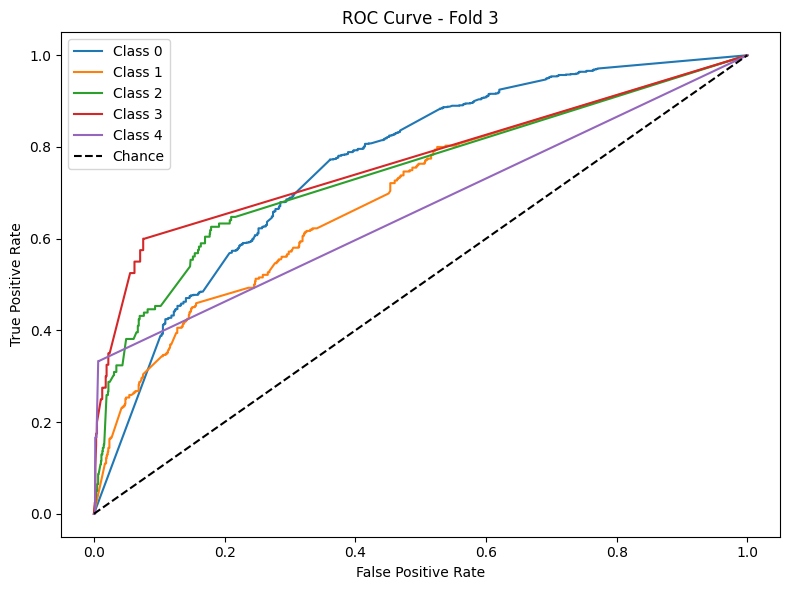

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.86      0.81       999
           1       0.51      0.39      0.44       356
           2       0.48      0.37      0.42       138
           3       0.15      0.10      0.12        39
           4       0.00      0.00      0.00         6

    accuracy                           0.69      1538
   macro avg       0.38      0.34      0.36      1538
weighted avg       0.66      0.69      0.67      1538



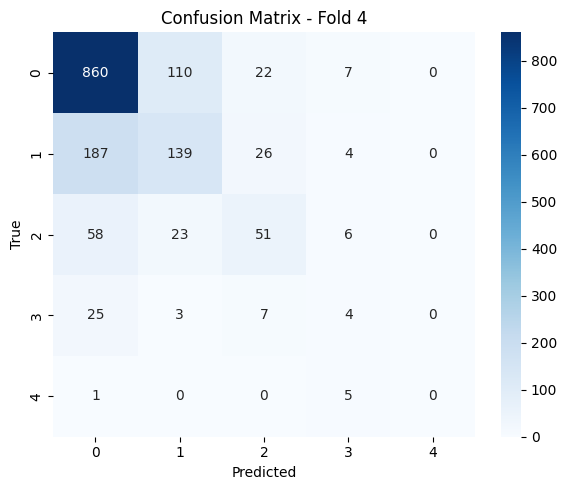

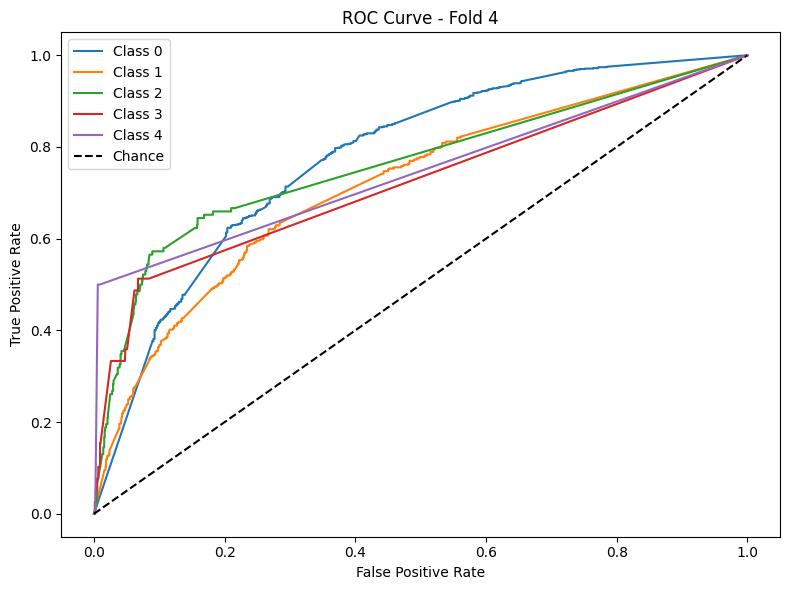


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.85      0.81       999
           1       0.48      0.41      0.44       356
           2       0.38      0.28      0.32       138
           3       0.24      0.15      0.19        39
           4       0.17      0.17      0.17         6

    accuracy                           0.67      1538
   macro avg       0.41      0.37      0.38      1538
weighted avg       0.65      0.67      0.66      1538



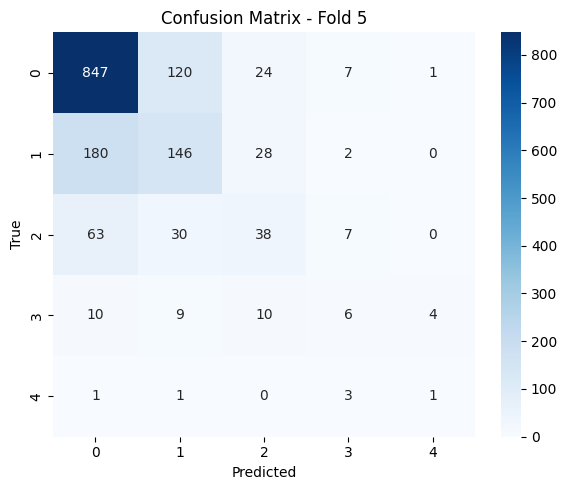

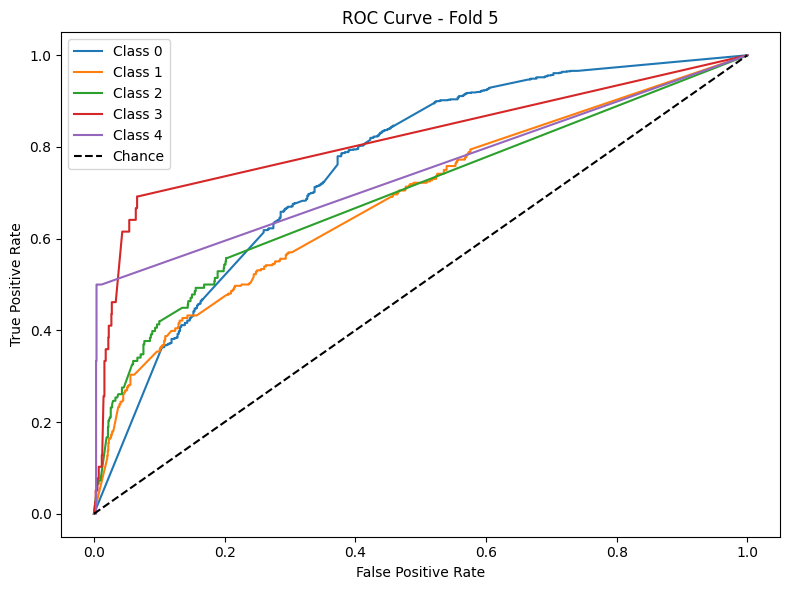


Average Accuracy: 0.6723
Average F1 Macro: 0.3780
Average AUC: 0.7328


In [5]:
phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n===================================")
    print(f"\n======= Training Phase {i} ========")
    print(f"\n===================================")
    sample = False
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


## Predict on Test Data

In [6]:
import pandas as pd
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

def predict_on_test(test_file_path, model_file, scaler_file, school_mapping_file):
    # Load model, scaler, and mapping
    model = joblib.load(model_file)
    scaler = joblib.load(scaler_file)
    mapping = joblib.load(school_mapping_file)

    # Load and preprocess test data
    df_test = pd.read_csv(test_file_path)
    y_test = df_test['label_encoded']
    X_test = df_test.drop(columns=['user_id', 'course_id', 'label_encoded', 'label', 'total_score'], axis=1)

    # Apply school mapping
    if 'school' in X_test.columns:
        X_test['school'] = X_test['school'].map(mapping).fillna(0).astype(int)

    # Scale features
    X_test_scaled = scaler.transform(X_test)

    # Predict
    y_pred = model.predict(X_test_scaled)
    y_proba = model.predict_proba(X_test_scaled)

    # Classification Report
    print("\nClassification Report:\n")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.tight_layout()
    plt.show()

    # AUC Score
    classes = model.classes_
    y_test_bin = label_binarize(y_test, classes=classes)
    auc_score = roc_auc_score(y_test_bin, y_proba, average='macro', multi_class='ovr')
    print(f"\nTest AUC (macro-average, OVR): {auc_score:.4f}")

    # Plot ROC Curves
    plt.figure(figsize=(8, 6))
    for i, cls in enumerate(classes):
        fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_proba[:, i])
        plt.plot(fpr, tpr, label=f'Class {cls}')

    plt.plot([0, 1], [0, 1], 'k--', label='Chance')
    plt.title('ROC Curves for Test Set')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.tight_layout()
    plt.show()

    return y_pred


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       568
           1       0.15      0.22      0.18        63
           2       0.24      0.16      0.19        43
           3       0.00      0.00      0.00        15
           4       0.00      0.00      0.00         9

    accuracy                           0.74       698
   macro avg       0.25      0.25      0.25       698
weighted avg       0.73      0.74      0.73       698



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


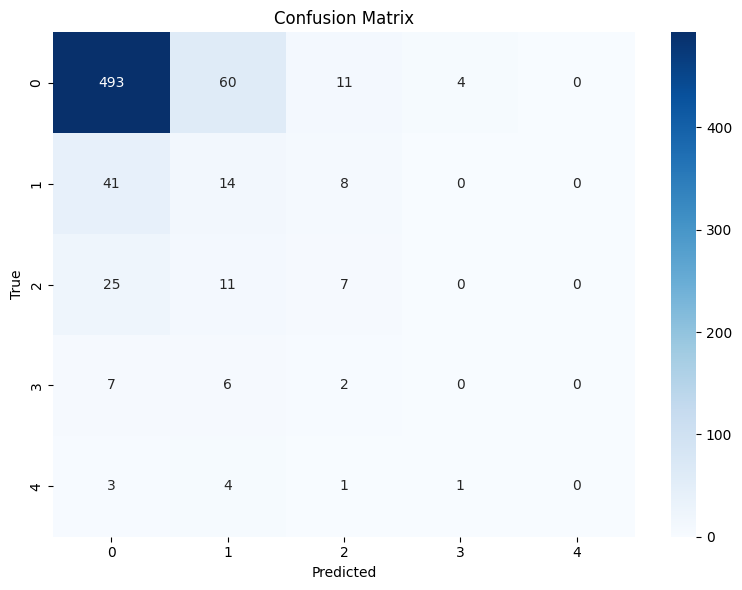


Test AUC (macro-average, OVR): 0.5531


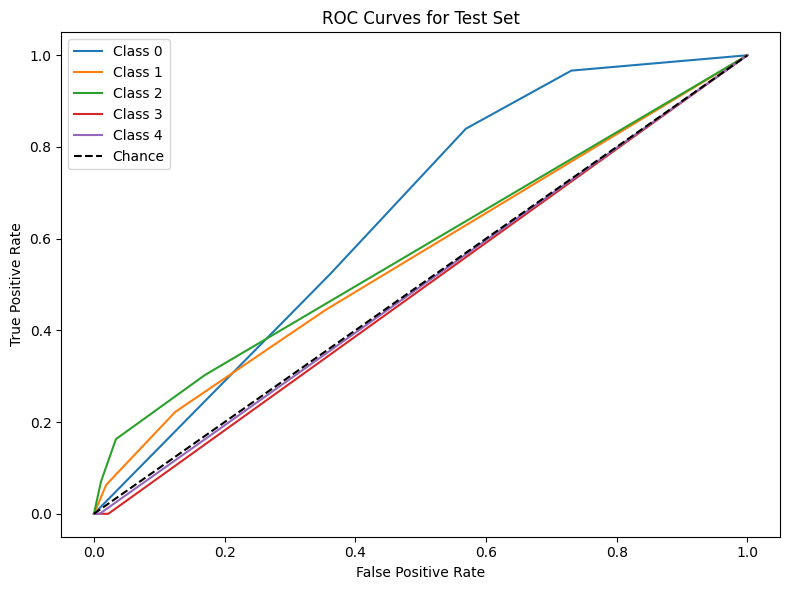

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.85      0.91      0.88       544
           1       0.14      0.12      0.13        59
           2       0.11      0.10      0.10        42
           3       0.00      0.00      0.00        14
           4       0.00      0.00      0.00         9

    accuracy                           0.76       668
   macro avg       0.22      0.22      0.22       668
weighted avg       0.71      0.76      0.73       668



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


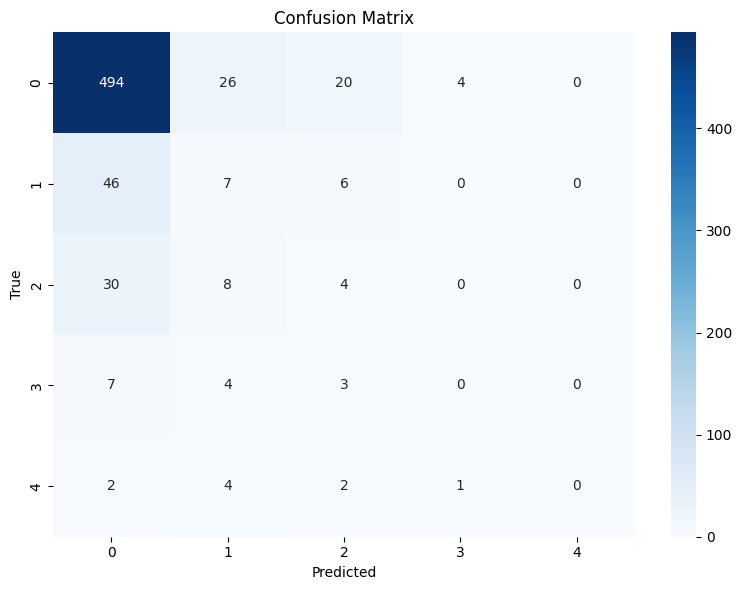


Test AUC (macro-average, OVR): 0.5881


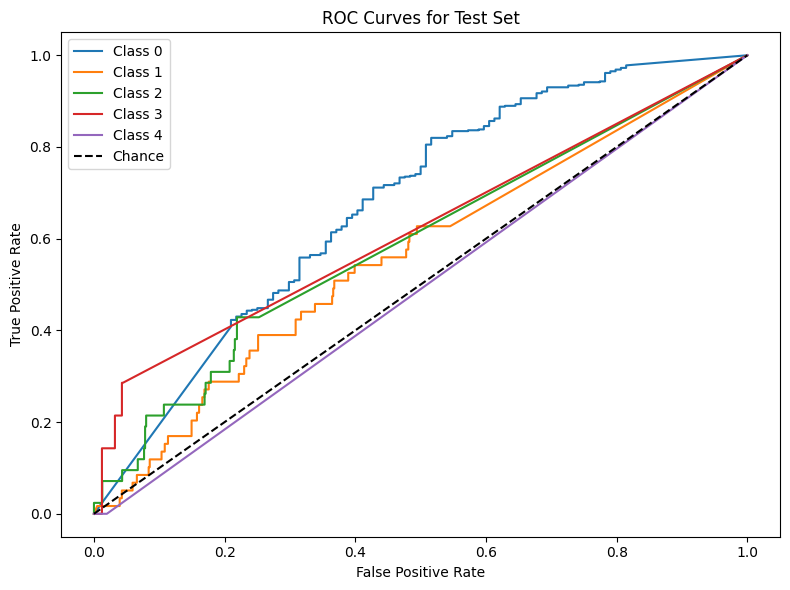

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.86      0.90      0.88       455
           1       0.18      0.08      0.11        52
           2       0.11      0.21      0.14        29
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.76       554
   macro avg       0.23      0.24      0.23       554
weighted avg       0.73      0.76      0.74       554



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


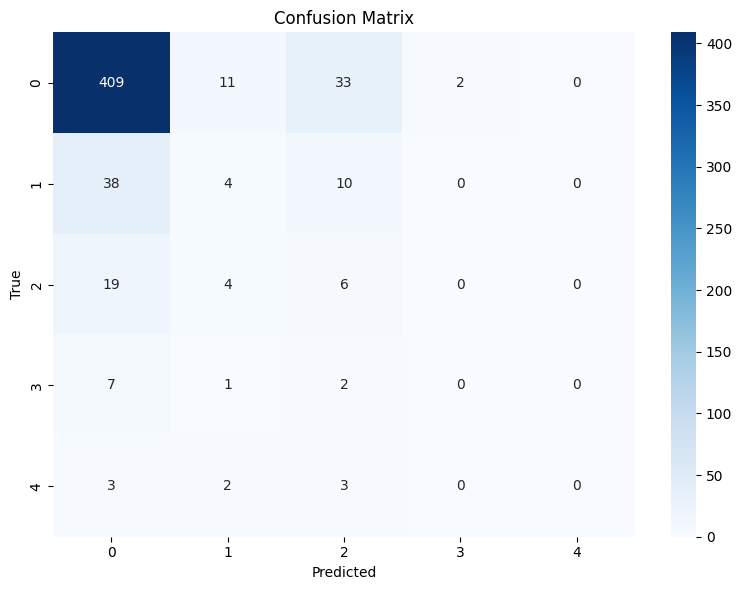


Test AUC (macro-average, OVR): 0.6247


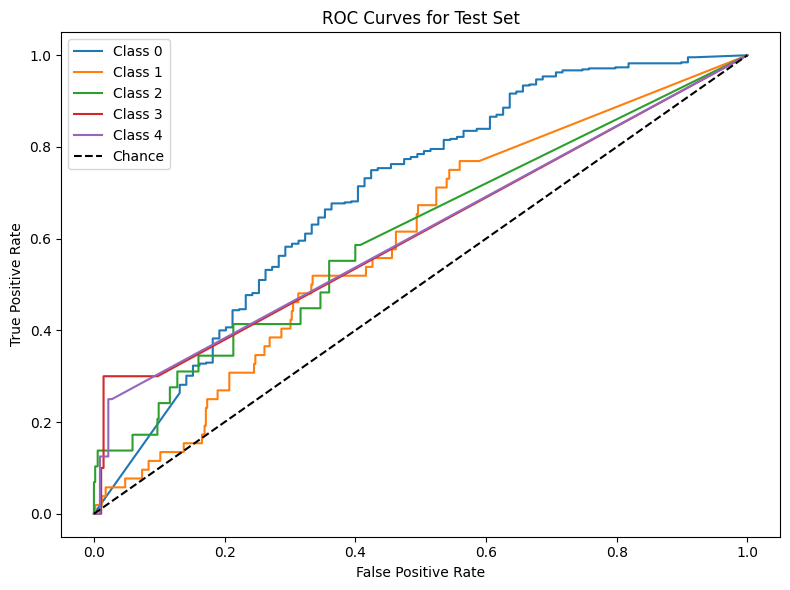

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.87      0.91      0.89       395
           1       0.08      0.05      0.06        40
           2       0.22      0.33      0.26        24
           3       0.00      0.00      0.00        10
           4       0.00      0.00      0.00         8

    accuracy                           0.77       477
   macro avg       0.23      0.26      0.24       477
weighted avg       0.74      0.77      0.76       477



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


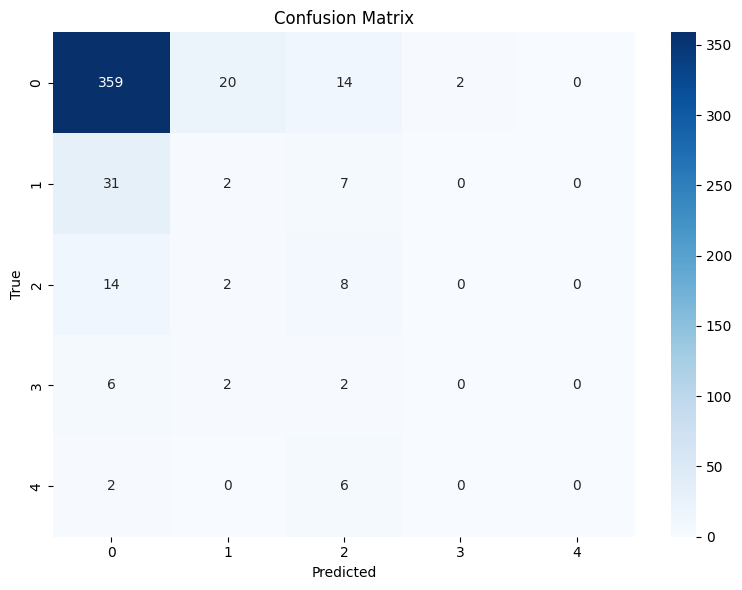


Test AUC (macro-average, OVR): 0.6311


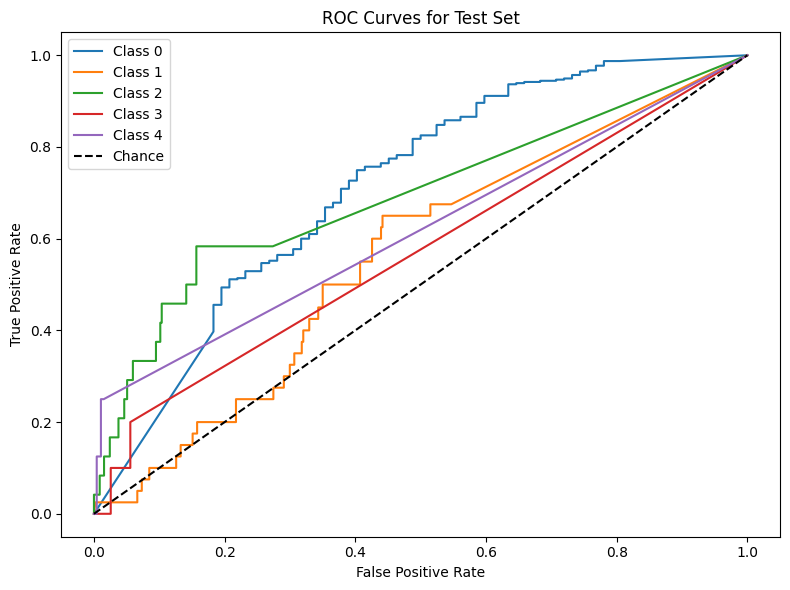

In [7]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)


# Add SMOTE Sample


=== Training Phase 1 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'weights': 'distance', 'p': 1, 'n_neighbors': 7, 'algorithm': 'auto'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78      1785
           1       0.44      0.44      0.44       604
           2       0.33      0.35      0.34       258
           3       0.28      0.25      0.27        59
           4       0.12      0.11      0.12         9

    accuracy                           0.65      2715
   macro avg       0.39      0.39      0.39      2715
weighted avg       0.65      0.65      0.65      2715



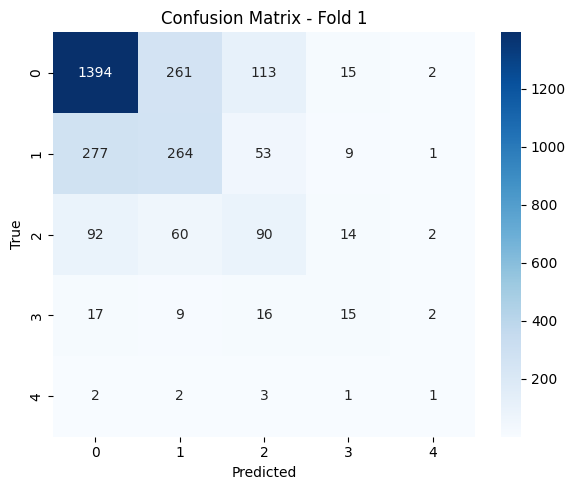

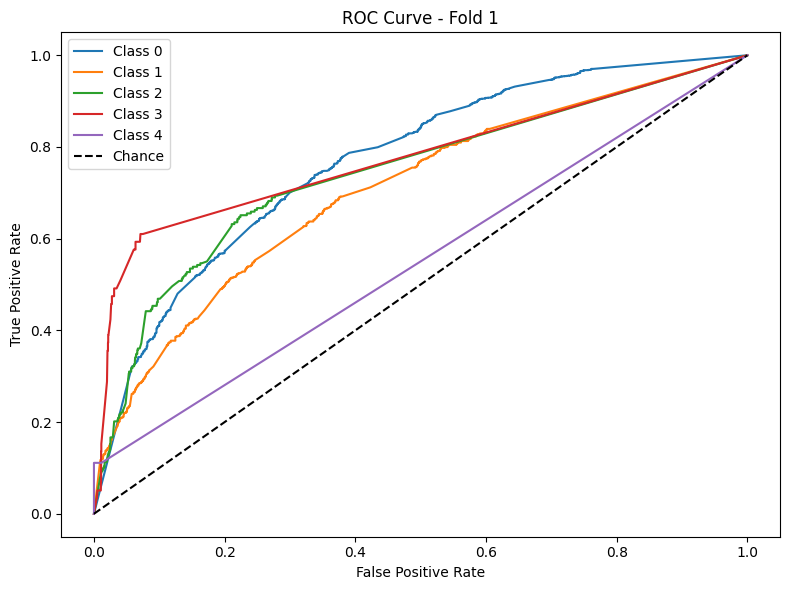


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.78      0.78      1786
           1       0.42      0.40      0.41       603
           2       0.42      0.41      0.42       258
           3       0.26      0.22      0.24        59
           4       0.50      0.50      0.50         8

    accuracy                           0.65      2714
   macro avg       0.47      0.46      0.47      2714
weighted avg       0.65      0.65      0.65      2714



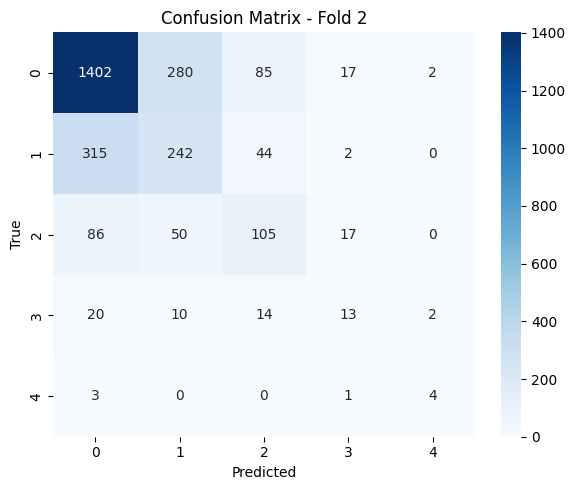

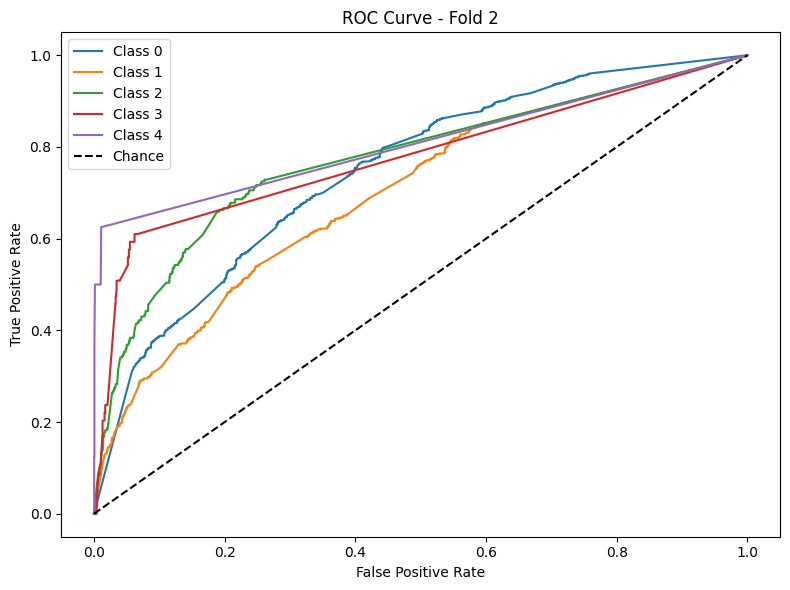


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.77      0.78      1786
           1       0.41      0.41      0.41       603
           2       0.37      0.40      0.38       258
           3       0.37      0.37      0.37        59
           4       0.14      0.12      0.13         8

    accuracy                           0.65      2714
   macro avg       0.41      0.41      0.41      2714
weighted avg       0.65      0.65      0.65      2714



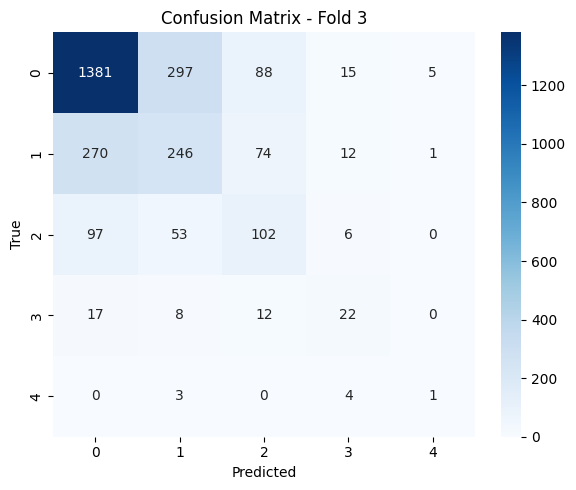

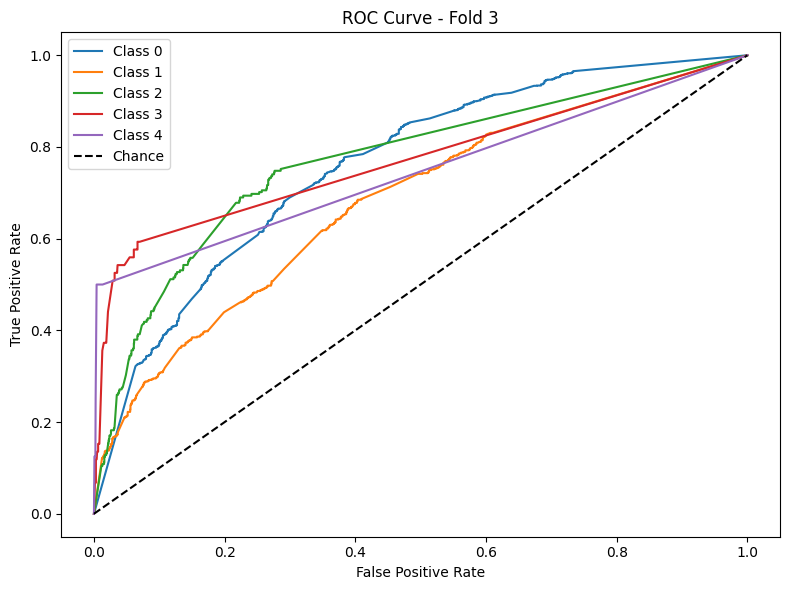


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79      1785
           1       0.42      0.47      0.44       603
           2       0.40      0.36      0.38       258
           3       0.10      0.08      0.09        59
           4       0.25      0.11      0.15         9

    accuracy                           0.66      2714
   macro avg       0.39      0.36      0.37      2714
weighted avg       0.66      0.66      0.66      2714



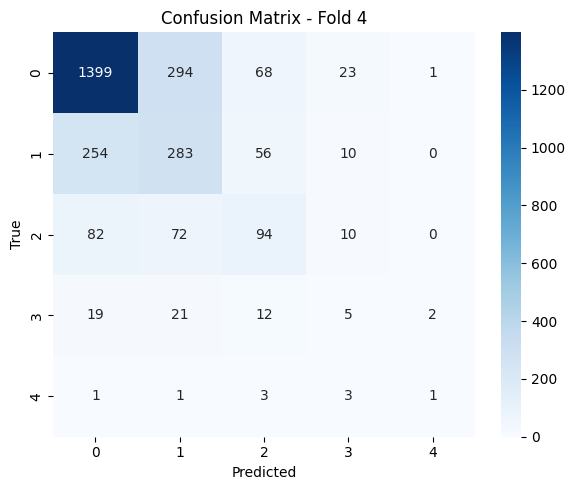

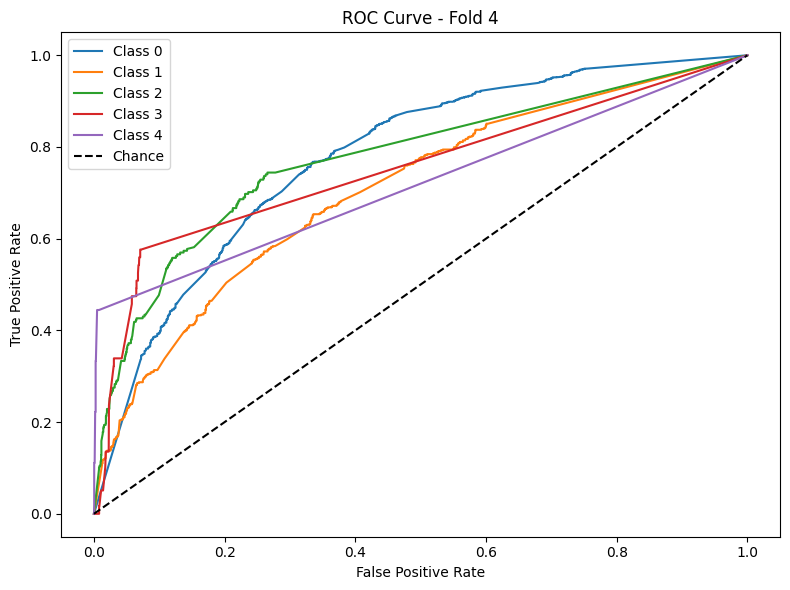


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78      1785
           1       0.41      0.42      0.42       603
           2       0.40      0.40      0.40       258
           3       0.29      0.24      0.26        59
           4       0.25      0.11      0.15         9

    accuracy                           0.65      2714
   macro avg       0.43      0.39      0.40      2714
weighted avg       0.65      0.65      0.65      2714



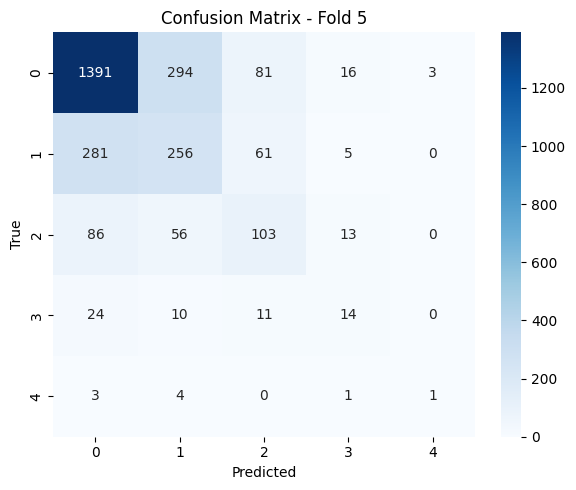

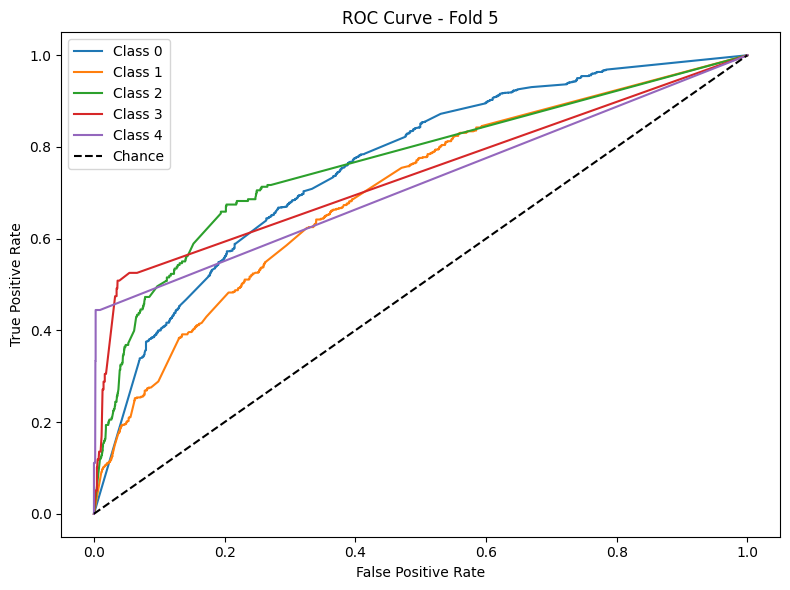


Average Accuracy: 0.6506
Average F1 Macro: 0.4091
Average AUC: 0.7396

=== Training Phase 2 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'weights': 'distance', 'p': 2, 'n_neighbors': 7, 'algorithm': 'ball_tree'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.76      0.77      1489
           1       0.37      0.40      0.38       488
           2       0.35      0.35      0.35       220
           3       0.24      0.26      0.25        54
           4       0.14      0.11      0.12         9

    accuracy                           0.62      2260
   macro avg       0.37      0.37      0.37      2260
weighted avg       0.63      0.62      0.63      2260



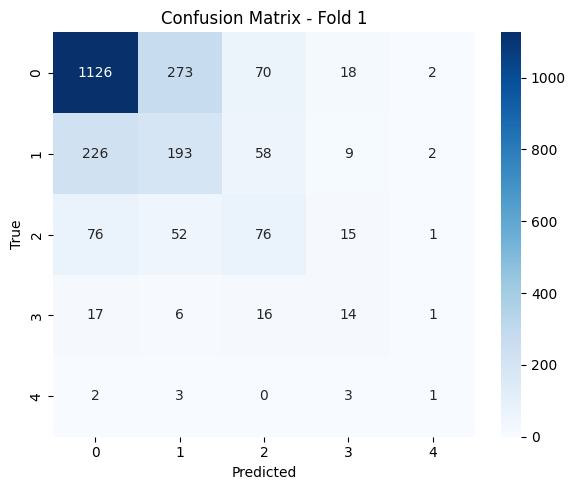

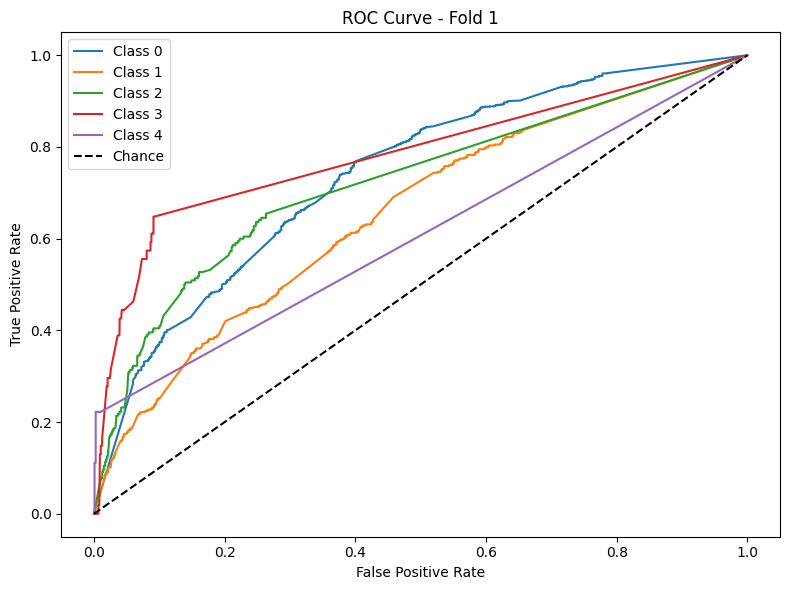


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.75      0.76      1489
           1       0.36      0.40      0.38       489
           2       0.41      0.38      0.40       219
           3       0.27      0.24      0.25        55
           4       0.17      0.12      0.14         8

    accuracy                           0.62      2260
   macro avg       0.39      0.38      0.38      2260
weighted avg       0.63      0.62      0.63      2260



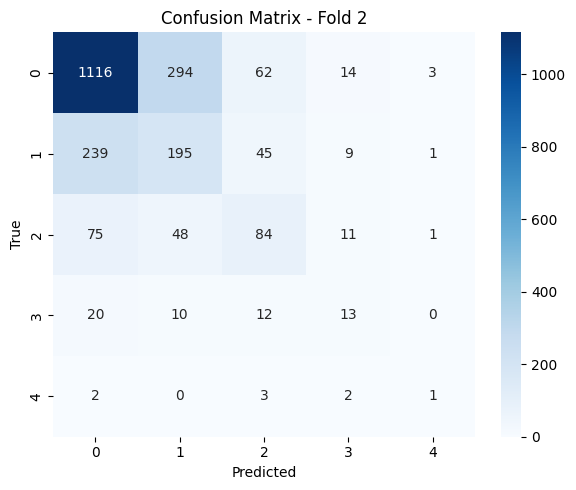

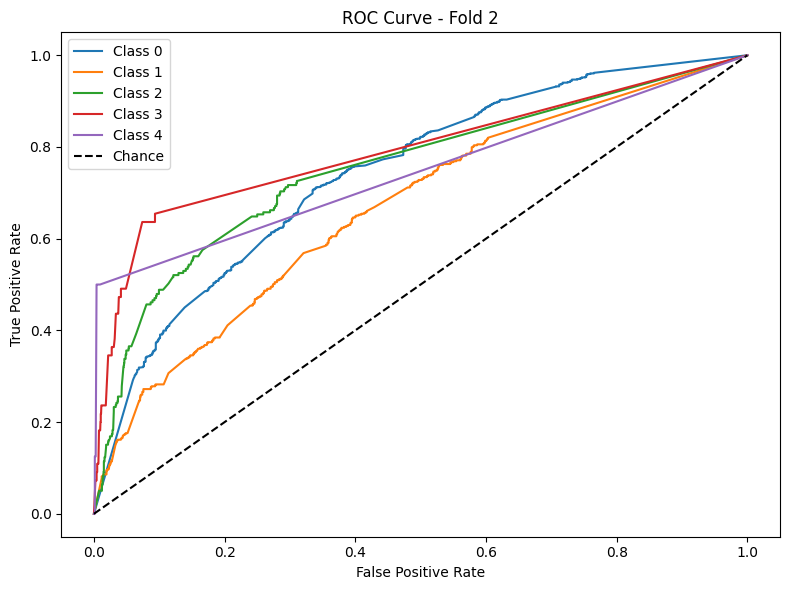


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77      1489
           1       0.37      0.39      0.38       489
           2       0.40      0.41      0.40       219
           3       0.19      0.28      0.23        54
           4       0.20      0.12      0.15         8

    accuracy                           0.63      2259
   macro avg       0.39      0.39      0.39      2259
weighted avg       0.64      0.63      0.63      2259



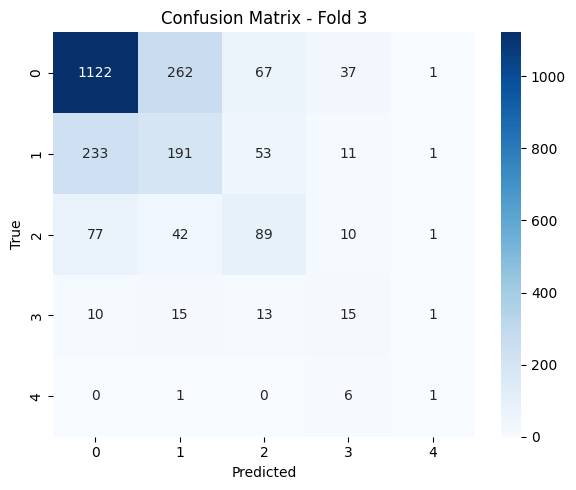

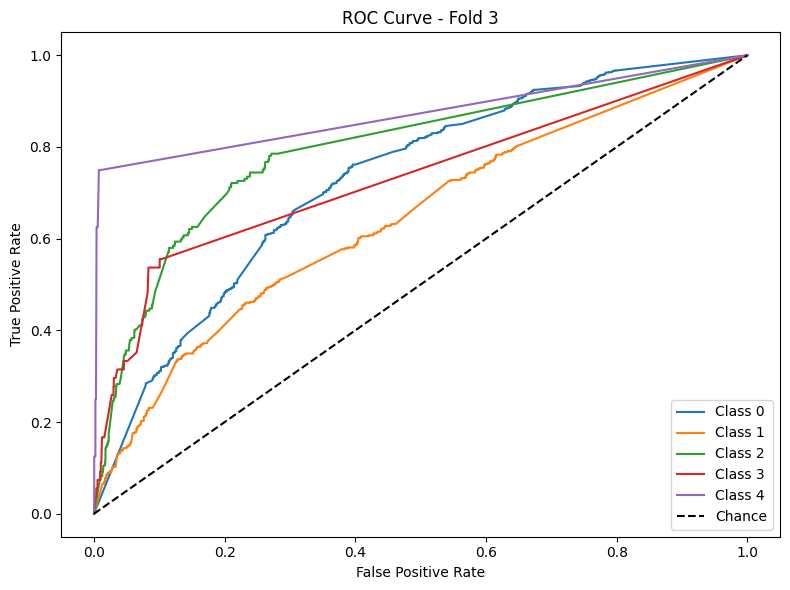


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.75      0.76      1489
           1       0.39      0.39      0.39       489
           2       0.32      0.34      0.33       219
           3       0.15      0.15      0.15        54
           4       0.33      0.50      0.40         8

    accuracy                           0.62      2259
   macro avg       0.39      0.43      0.40      2259
weighted avg       0.62      0.62      0.62      2259



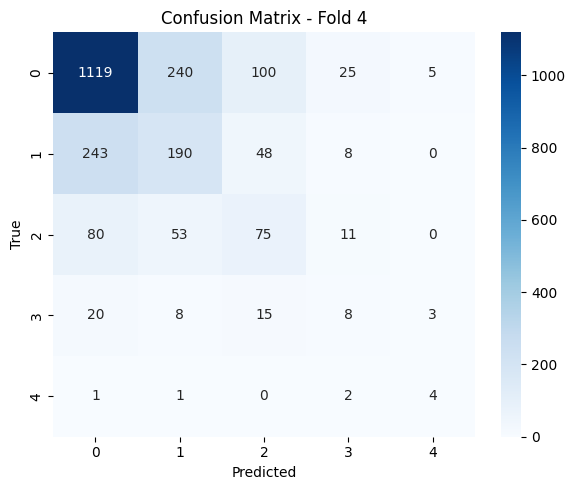

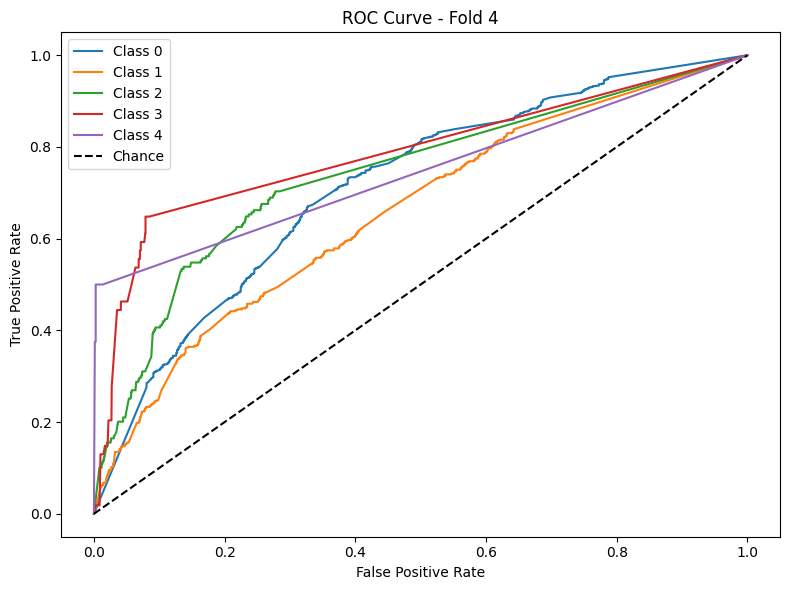


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.76      0.77      1490
           1       0.39      0.41      0.40       488
           2       0.32      0.36      0.33       219
           3       0.12      0.13      0.12        54
           4       0.10      0.12      0.11         8

    accuracy                           0.63      2259
   macro avg       0.34      0.35      0.35      2259
weighted avg       0.64      0.63      0.63      2259



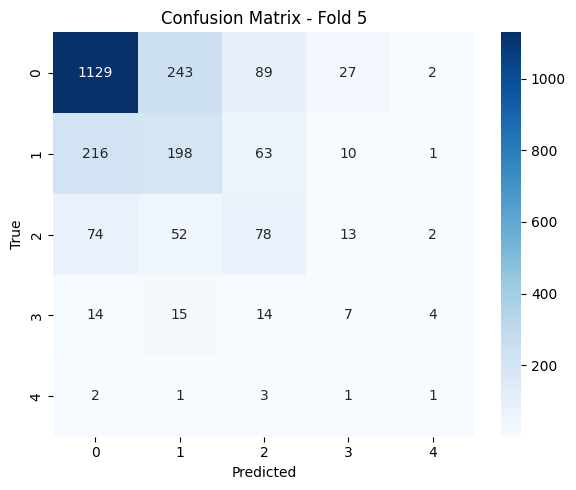

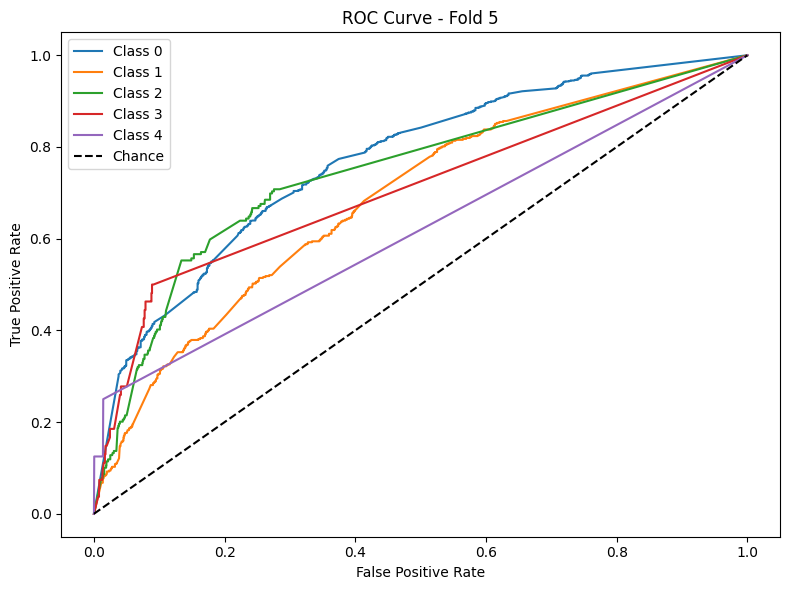


Average Accuracy: 0.6237
Average F1 Macro: 0.3793
Average AUC: 0.7258

=== Training Phase 3 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'weights': 'distance', 'p': 1, 'n_neighbors': 9, 'algorithm': 'auto'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.76      0.77      1361
           1       0.39      0.41      0.40       459
           2       0.38      0.43      0.40       198
           3       0.16      0.22      0.19        49
           4       0.00      0.00      0.00         7

    accuracy                           0.63      2074
   macro avg       0.34      0.36      0.35      2074
weighted avg       0.65      0.63      0.64      2074



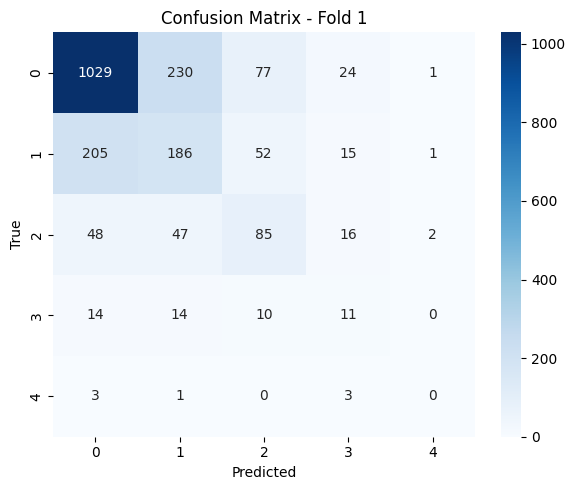

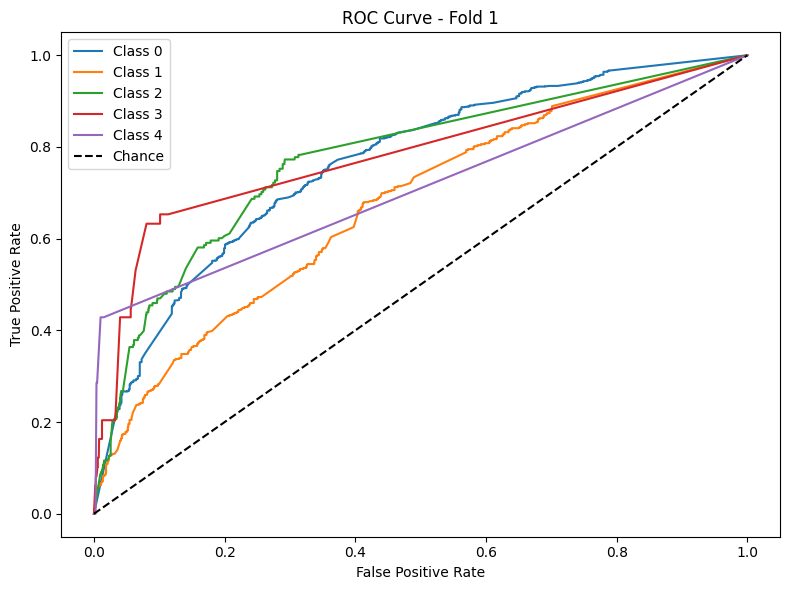


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.78      0.78      1360
           1       0.39      0.42      0.40       459
           2       0.39      0.36      0.38       198
           3       0.15      0.18      0.17        50
           4       0.50      0.14      0.22         7

    accuracy                           0.64      2074
   macro avg       0.44      0.37      0.39      2074
weighted avg       0.64      0.64      0.64      2074



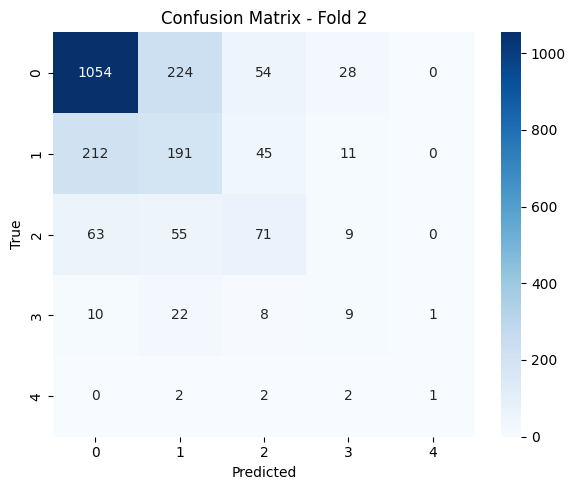

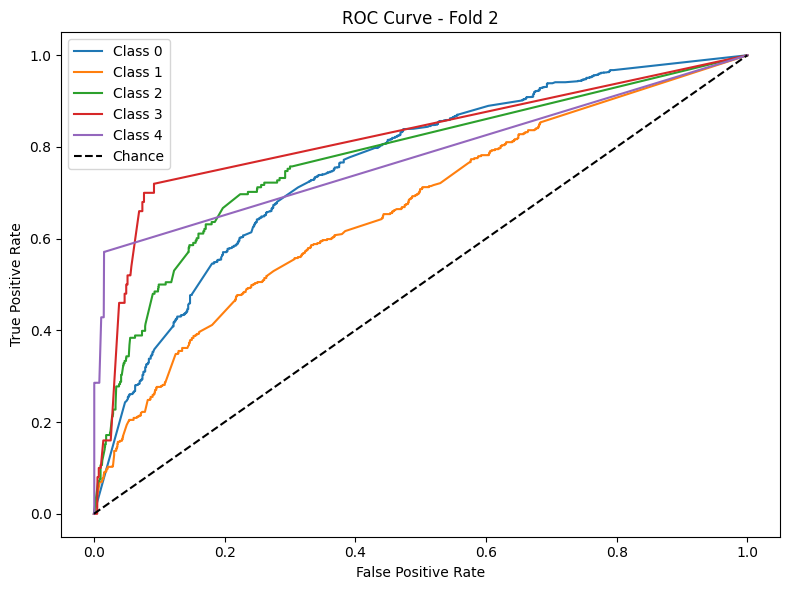


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.78      0.78      1360
           1       0.42      0.39      0.40       459
           2       0.35      0.39      0.37       198
           3       0.30      0.30      0.30        50
           4       0.20      0.14      0.17         7

    accuracy                           0.65      2074
   macro avg       0.41      0.40      0.40      2074
weighted avg       0.65      0.65      0.65      2074



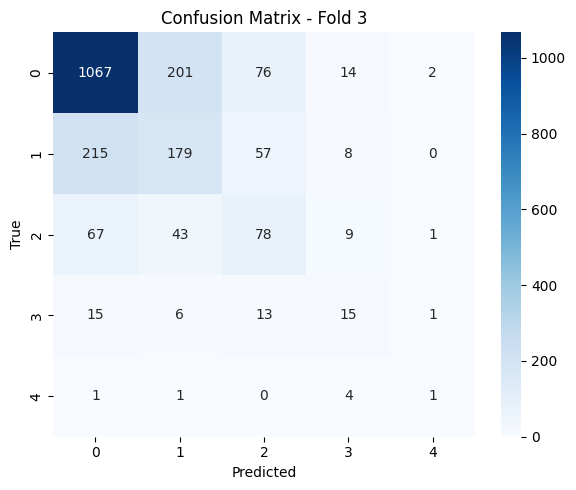

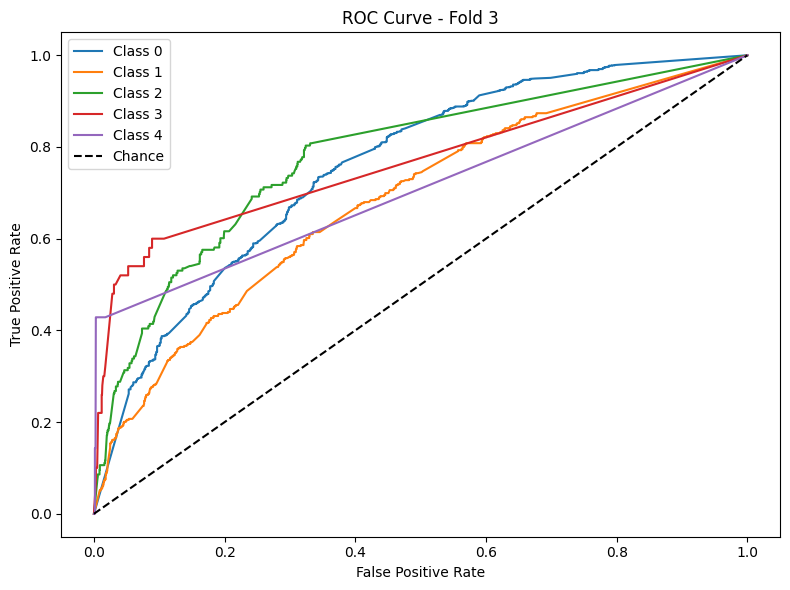


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.74      0.76      1360
           1       0.36      0.40      0.38       459
           2       0.35      0.36      0.35       198
           3       0.21      0.26      0.23        50
           4       0.50      0.14      0.22         7

    accuracy                           0.62      2074
   macro avg       0.44      0.38      0.39      2074
weighted avg       0.63      0.62      0.62      2074



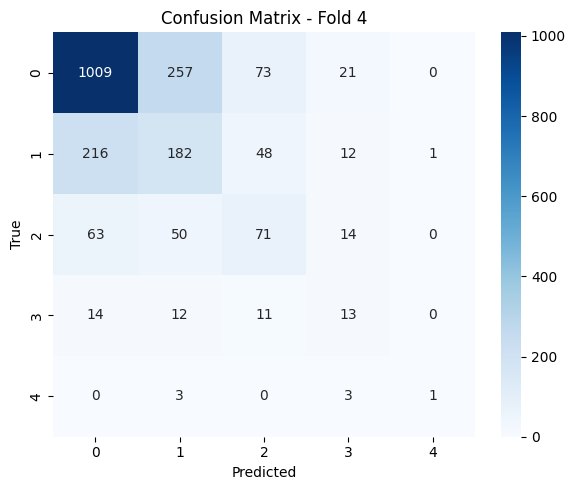

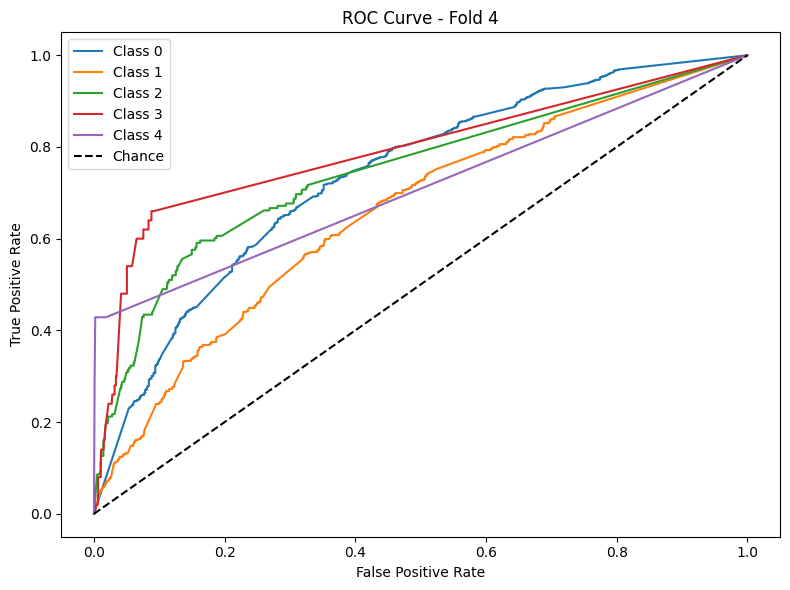


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.76      0.77      1360
           1       0.38      0.41      0.39       460
           2       0.39      0.38      0.38       197
           3       0.25      0.31      0.28        49
           4       0.00      0.00      0.00         7

    accuracy                           0.63      2073
   macro avg       0.36      0.37      0.36      2073
weighted avg       0.64      0.63      0.63      2073



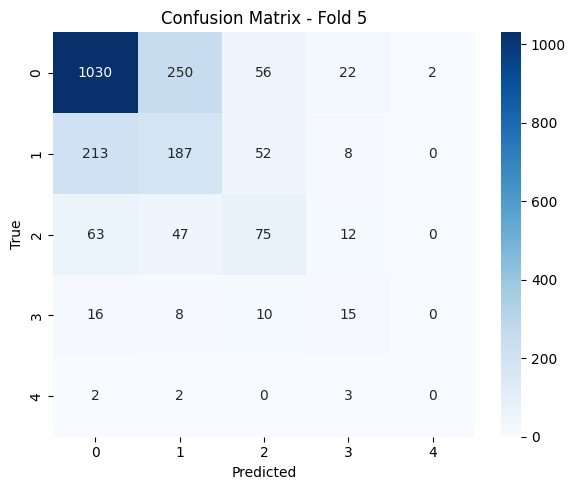

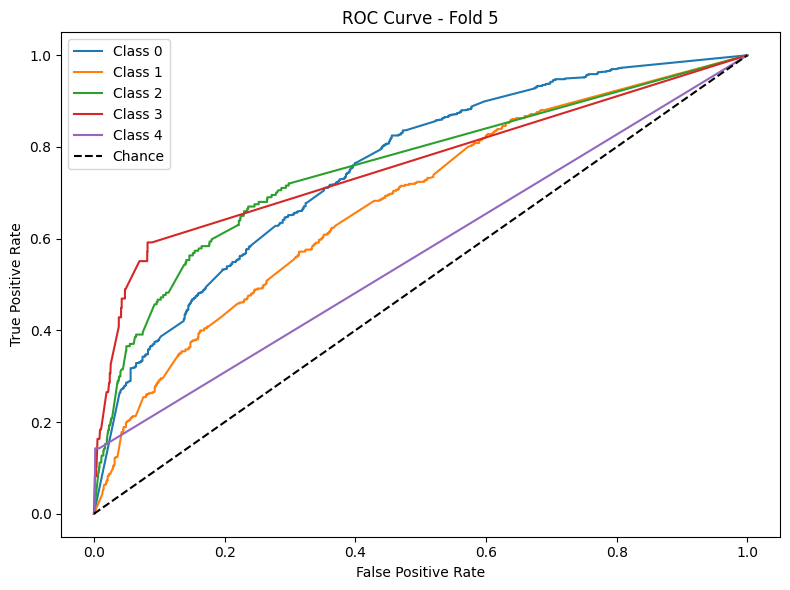


Average Accuracy: 0.6327
Average F1 Macro: 0.3796
Average AUC: 0.7338

=== Training Phase 4 ===
Fitting 3 folds for each of 10 candidates, totalling 30 fits
[Fold 1] Best Parameters Found: {'weights': 'distance', 'p': 1, 'n_neighbors': 5, 'algorithm': 'kd_tree'}

Fold 1 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.72      0.75      1000
           1       0.36      0.39      0.38       355
           2       0.28      0.37      0.32       139
           3       0.27      0.31      0.29        39
           4       0.33      0.50      0.40         6

    accuracy                           0.60      1539
   macro avg       0.41      0.46      0.43      1539
weighted avg       0.63      0.60      0.61      1539



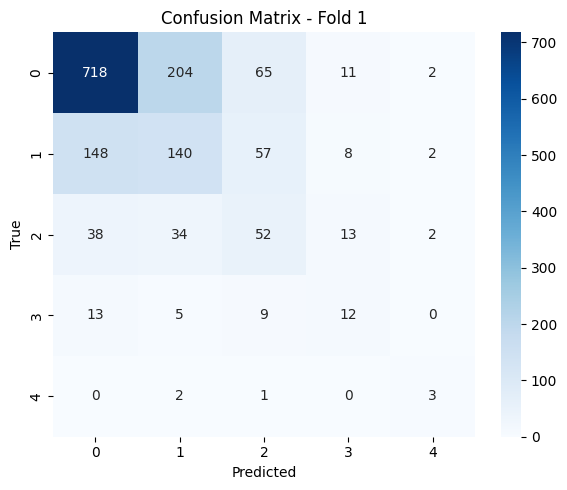

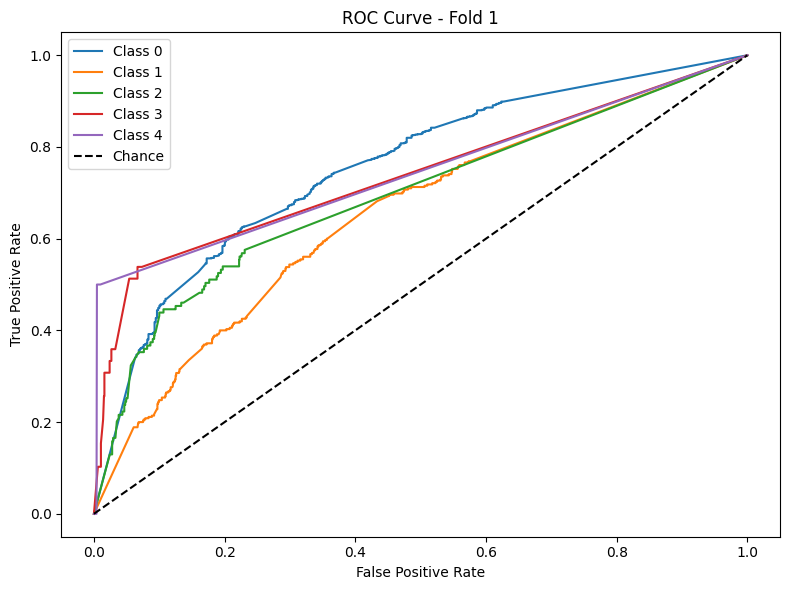


Fold 2 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77      1000
           1       0.41      0.45      0.43       355
           2       0.40      0.43      0.42       139
           3       0.22      0.20      0.21        40
           4       0.00      0.00      0.00         5

    accuracy                           0.64      1539
   macro avg       0.36      0.37      0.36      1539
weighted avg       0.64      0.64      0.64      1539



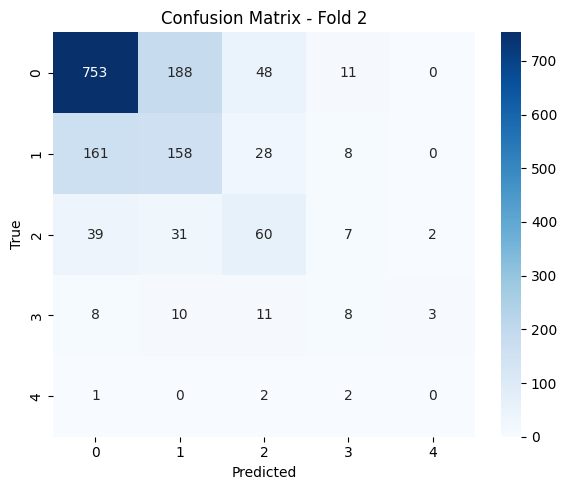

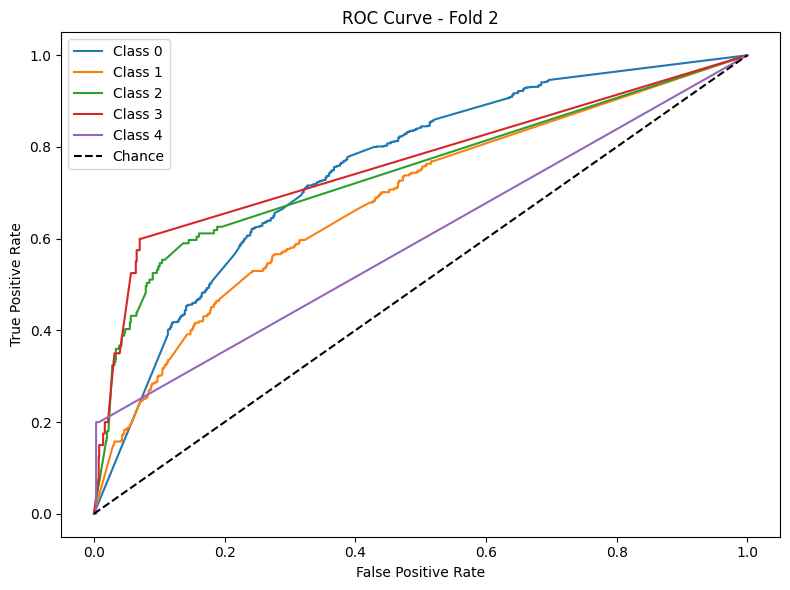


Fold 3 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.75      0.77       999
           1       0.43      0.47      0.45       355
           2       0.33      0.37      0.35       139
           3       0.29      0.23      0.25        40
           4       0.20      0.17      0.18         6

    accuracy                           0.64      1539
   macro avg       0.41      0.40      0.40      1539
weighted avg       0.65      0.64      0.64      1539



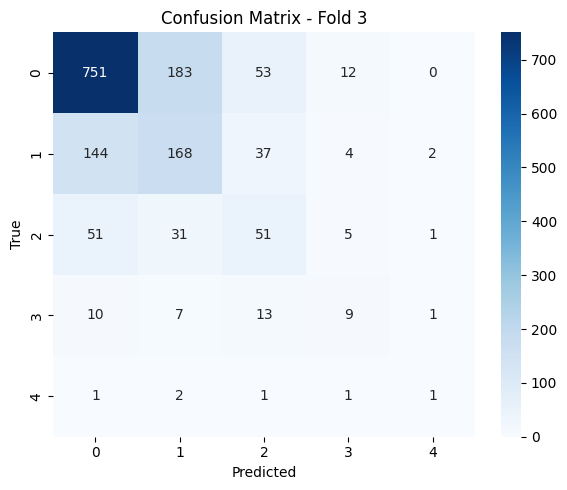

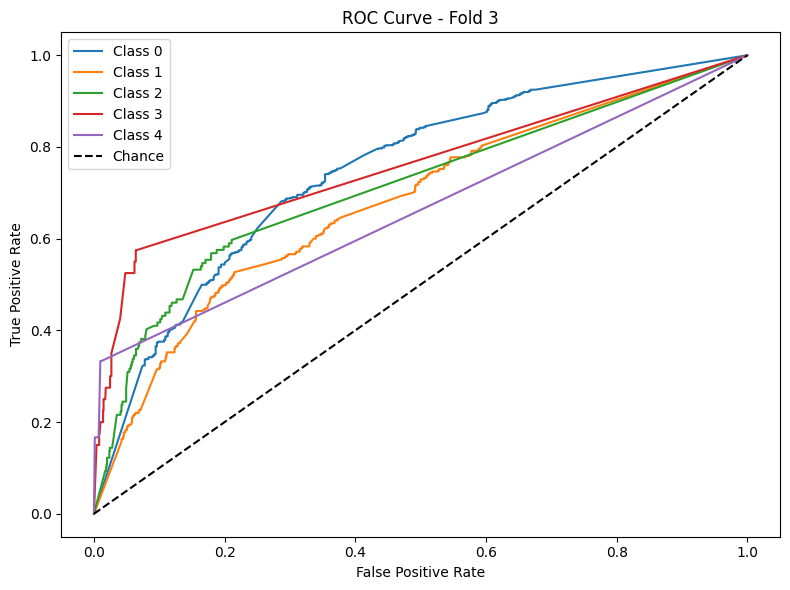


Fold 4 Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.80      0.79       999
           1       0.48      0.43      0.45       356
           2       0.38      0.41      0.39       138
           3       0.08      0.10      0.09        39
           4       0.00      0.00      0.00         6

    accuracy                           0.66      1538
   macro avg       0.34      0.35      0.35      1538
weighted avg       0.66      0.66      0.66      1538



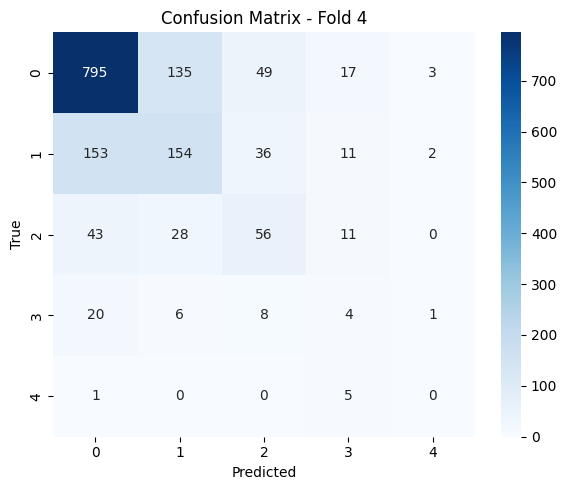

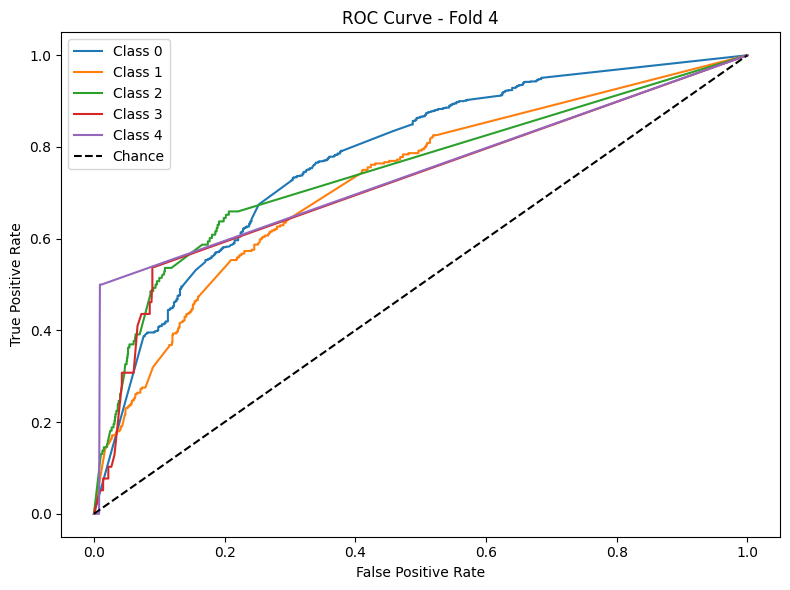


Fold 5 Classification Report:
               precision    recall  f1-score   support

           0       0.78      0.71      0.74       999
           1       0.38      0.45      0.41       356
           2       0.28      0.30      0.29       138
           3       0.23      0.26      0.24        39
           4       0.20      0.17      0.18         6

    accuracy                           0.60      1538
   macro avg       0.37      0.38      0.37      1538
weighted avg       0.62      0.60      0.61      1538



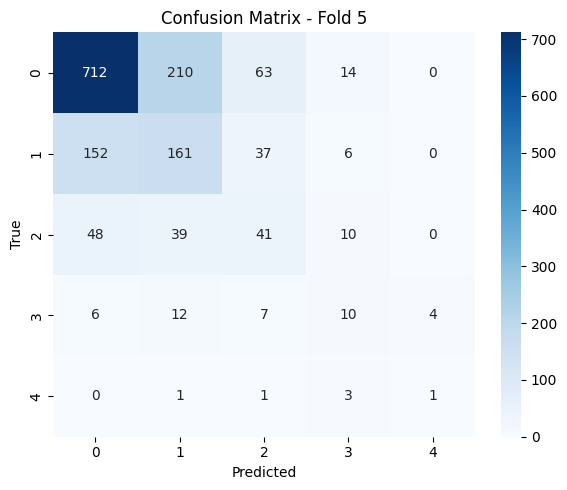

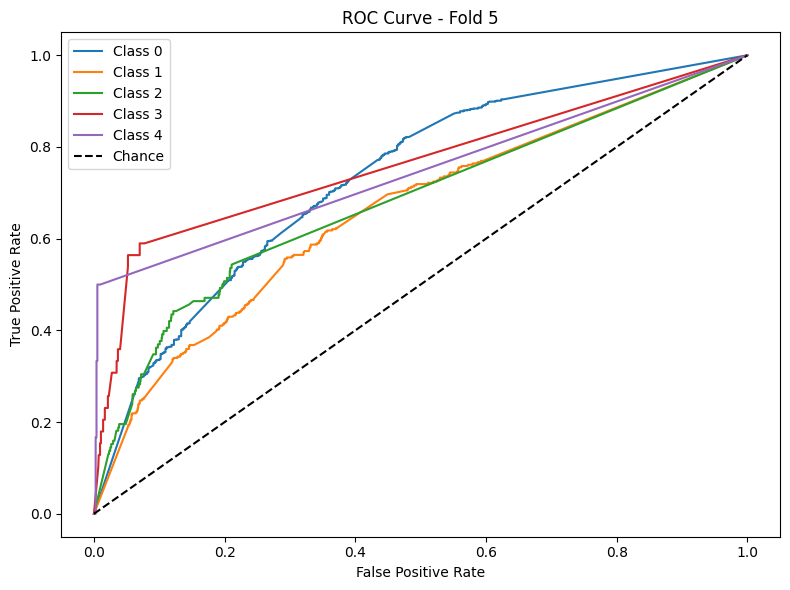


Average Accuracy: 0.6263
Average F1 Macro: 0.3822
Average AUC: 0.7193


In [8]:
phase_paths = [f"/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}" for i in range(1, 5)]
results = {}

for i, phase_path in enumerate(phase_paths, start=1):
    print(f"\n=== Training Phase {i} ===")
    sample = True
    model, scaler, best_fold, metrics = train_phase(phase_path, sample = sample)
    # Save best model & scaler
    if sample: 
        temp = "sample"
    else: temp = "no_sample"
    joblib.dump(model, f"best_model_{temp}_phase{i}.pkl")
    joblib.dump(scaler, f"best_scaler_{temp}_phase{i}.pkl")
    results[f"phase{i}"] = metrics


/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.88      0.74      0.81       568
           1       0.14      0.33      0.20        63
           2       0.19      0.21      0.20        43
           3       0.06      0.07      0.06        15
           4       0.17      0.11      0.13         9

    accuracy                           0.65       698
   macro avg       0.29      0.29      0.28       698
weighted avg       0.75      0.65      0.69       698



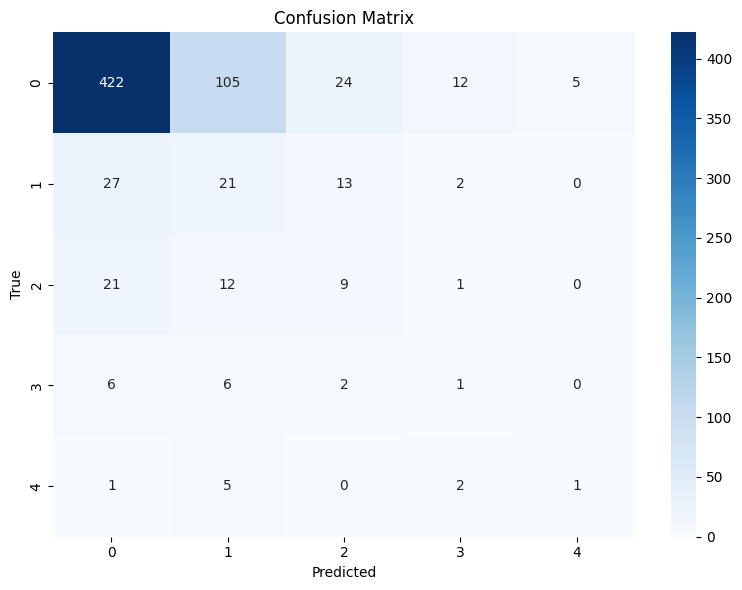


Test AUC (macro-average, OVR): 0.6067


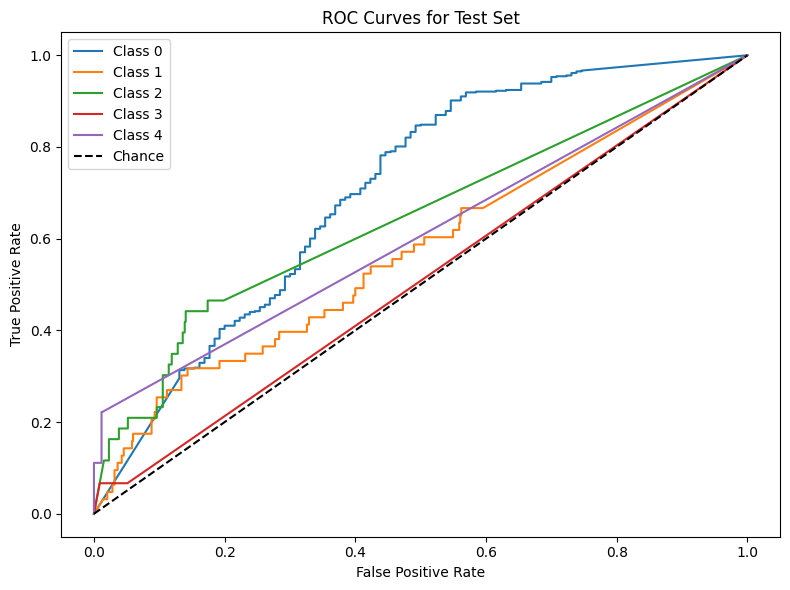

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.89      0.70      0.78       544
           1       0.14      0.29      0.19        59
           2       0.11      0.21      0.14        42
           3       0.12      0.21      0.15        14
           4       0.00      0.00      0.00         9

    accuracy                           0.62       668
   macro avg       0.25      0.28      0.25       668
weighted avg       0.75      0.62      0.67       668



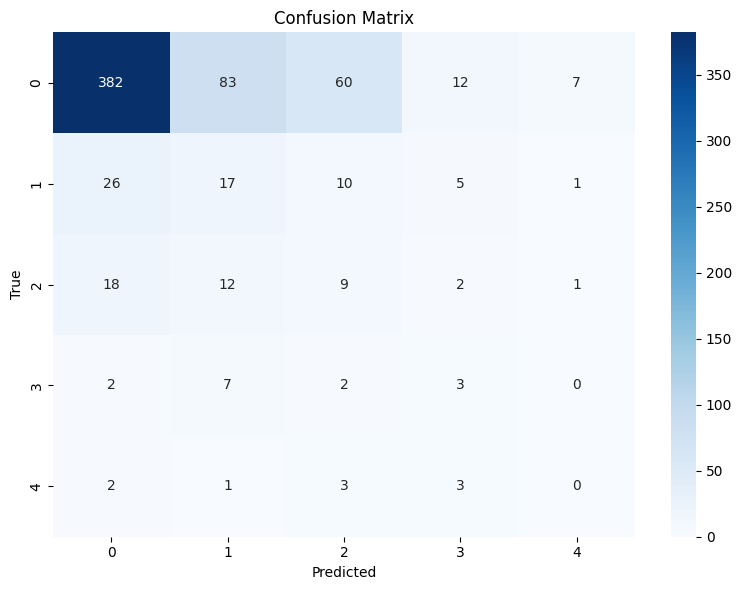


Test AUC (macro-average, OVR): 0.5858


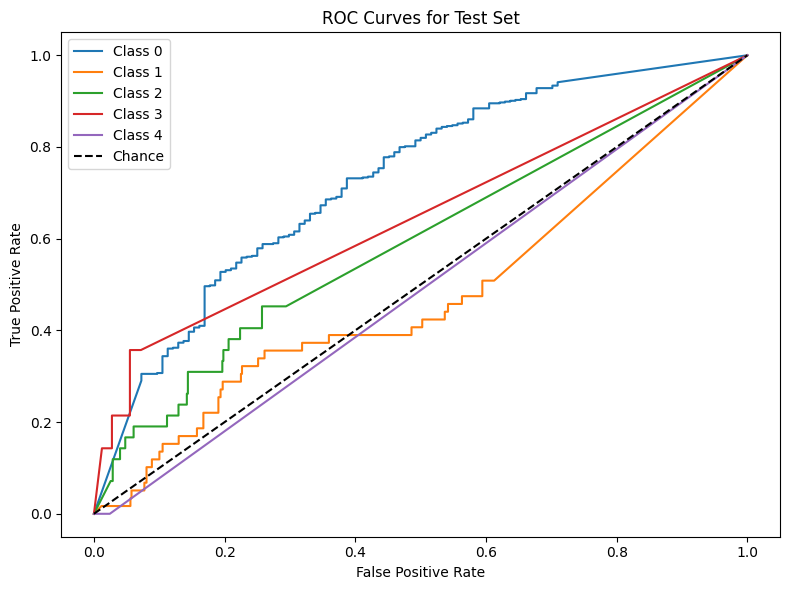

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.90      0.71      0.80       455
           1       0.10      0.12      0.11        52
           2       0.08      0.24      0.11        29
           3       0.15      0.50      0.23        10
           4       0.00      0.00      0.00         8

    accuracy                           0.62       554
   macro avg       0.25      0.31      0.25       554
weighted avg       0.76      0.62      0.67       554



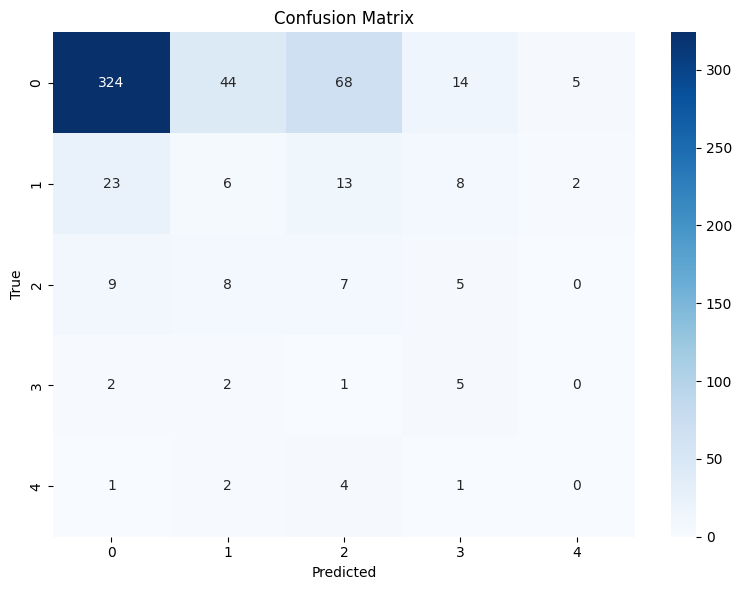


Test AUC (macro-average, OVR): 0.6151


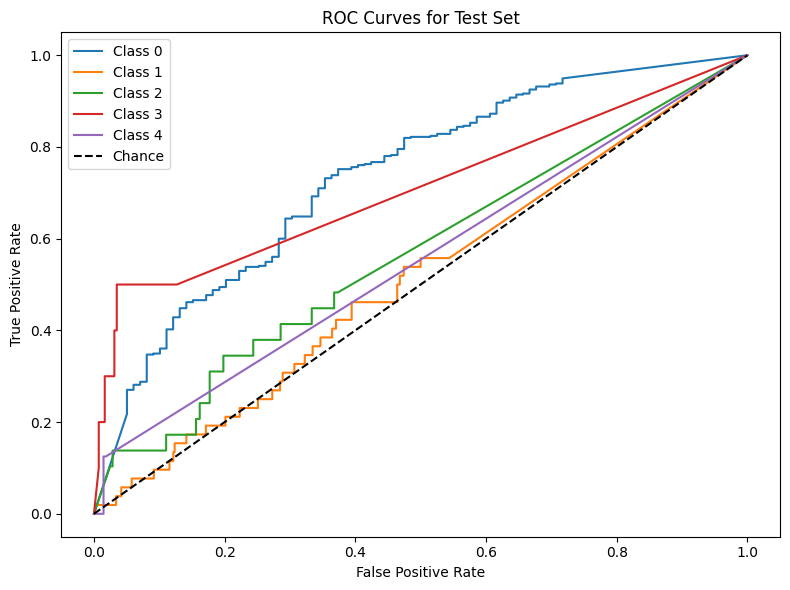

/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(



Classification Report:

              precision    recall  f1-score   support

           0       0.92      0.69      0.79       395
           1       0.19      0.35      0.25        40
           2       0.09      0.33      0.14        24
           3       0.00      0.00      0.00        10
           4       0.20      0.12      0.15         8

    accuracy                           0.62       477
   macro avg       0.28      0.30      0.26       477
weighted avg       0.78      0.62      0.68       477



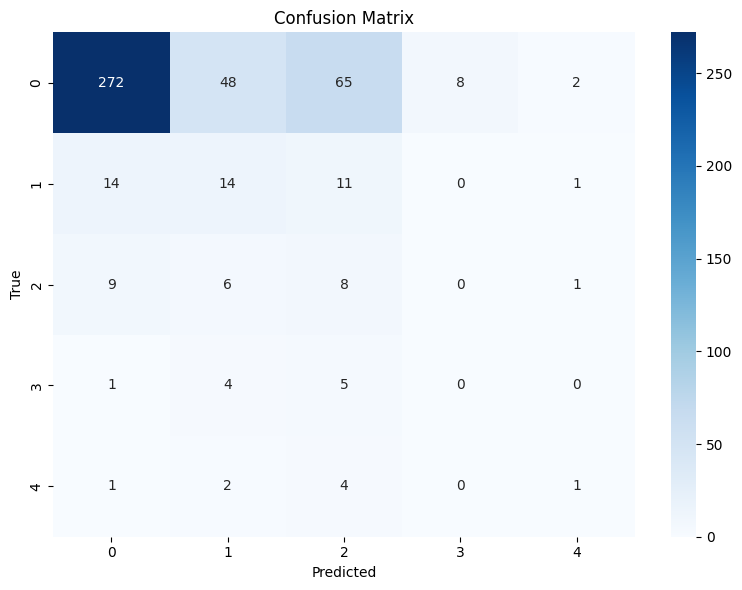


Test AUC (macro-average, OVR): 0.6143


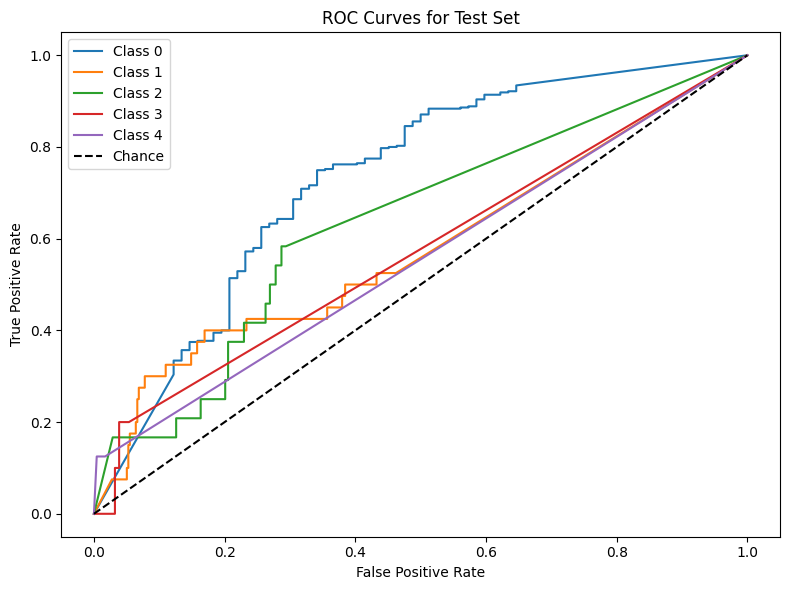

In [9]:
import glob

for i in range(1, 5):
    test_dir = f'/kaggle/input/filtered-final-data/phase{i}/user_train_phase_{i}_test.csv'
    
    # Get model and scaler using glob
    model_path = f'/kaggle/working/best_model_{temp}_phase{i}.pkl'
    scaler_path = f'/kaggle/working/best_scaler_{temp}_phase{i}.pkl'
    
    # School mapping path
    school_mapping_file = f'/kaggle/input/smotesvm-train-filtered-data/outputs/phase{i}/mappings/school_mapping.pkl'

    # Predict on test set
    predict_on_test(test_dir, model_path, scaler_path, school_mapping_file)
